<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import scipy # 用来做统计
import random
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn import metrics
import pandasql as ps

# 1. Data Sets Info

## 1.1 题目描述
计算广告是互联网最重要的商业模式之一，广告投放效果通常通过曝光、点击和转化各环节来衡量，大多数广告系统受广告效果数据回流的限制只能通过曝光或点击作为投放效果的衡量标准开展优化。[腾讯社交广告](http://ads.tencent.com)发挥特有的用户识别和转化跟踪数据能力，帮助广告主跟踪广告投放后的转化效果，基于广告转化数据训练转化率预估模型(pCVR，Predicted Conversion Rate)，在广告排序中引入pCVR因子优化广告投放效果，提升ROI。

本题目以移动App广告为研究对象，预测App广告点击后被激活的概率：pCVR=P(conversion=1 | Ad,User,Context)，即给定广告、用户和上下文情况下广告被点击后发生激活的概率。

## 1.2 测试数据
从训练数据时段随后1天(即第31天)的广告日志中按照与训练数据同样的采样方式抽取得到，测试数据文件(test.csv)每行代表一个测试样本，各字段之间由逗号分隔，顺序依次为：“instanceID，-1，clickTime，creativeID，userID，positionID，connectionType，telecomsOperator”。其中，instanceID唯一标识一个样本，-1代表label占位使用，表示待预测。

注意：__测试数据中没有 *conversionTime* 这一特征。__

### 1.2.1 评估方式
通过 Logarithmic Loss 评估（越小越好）。就是 Logistic Regression 的代价函数。

以下为评分代码：

In [3]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

## 1.3 训练数据
从腾讯社交广告系统中某一连续两周的日志中按照推广中的App和用户维度随机采样。
每一条训练样本即为一条广告点击日志(点击时间用clickTime表示)，样本label取值0或1，其中0表示点击后没有发生转化，1表示点击后有发生转化，如果label为1，还会提供转化回流时间(conversionTime，定义详见“FAQ”)。给定特征集如下：

### 1.3.1 广告特征
- __账户ID(advertiserID)__：腾讯社交广告的账户结构分为四级：账户——推广计划——广告——素材，账户对应一家特定的广告主。
- __推广计划ID(campaignID)__：推广计划是广告的集合，类似电脑文件夹功能。广告主可以将推广平台、预算限额、是否匀速投放等条件相同的广告放在同一个推广计划中，方便管理。
- __广告ID(adID)__：腾讯社交广告管理平台中的广告是指广告主创建的广告创意(或称广告素材)及广告展示相关设置，包含广告的基本信息(广告名称，投放时间等)，广告的推广目标，投放平台，投放的广告规格，所投放的广告创意，广告的受众(即广告的定向设置)，广告出价等信息。单个推广计划下的广告数不设上限。
- __素材ID(creativeID)__：展示给用户直接看到的广告内容，一条广告下可以有多组素材。
- __AppID(appID)__：广告推广的目标页面链接地址，即点击后想要展示给用户的页面，此处页面特指具体的App。多个推广计划或广告可以同时推广同一个App。
- __App分类(appCategory)__：App开发者设定的App类目标签，类目标签有两层，使用3位数字编码，百位数表示一级类目，十位个位数表示二级类目，如“210”表示一级类目编号为2，二级类目编号为10，类目未知或者无法获取时，标记为0。
- __App平台(appPlatform)__：App所属操作系统平台，取值为Android，iOS，未知。同一个appID只会属于一个平台。

### 1.3.2 用户特征
- __用户ID(userID)__：唯一标识一个用户
- __年龄(age)__：取值范围[0, 80]，其中0表示未知。
- __性别(gender)__：取值包括男，女，未知。
- __学历(education)__：用户当前最高学历，不区分在读生和毕业生，取值包括小学，初中，高中，专科，本科，硕士，博士，未知
- __婚恋状态(marriageStatus)__：用户当前感情状况，取值包括单身，新婚，已婚，未知。
- __育儿状态(haveBaby)__：用户当前孕育宝宝状态，取值包括孕育中，宝宝0~6个月，宝宝6~12个月，宝宝1~2岁，宝宝2~3岁，育儿但宝宝年龄未知，未知。
- __家乡/籍贯(hometown)__：用户出生地，取值具体到市级城市，使用二级编码，千位百位数表示省份，十位个位数表示省内城市，如1806表示省份编号为18，城市编号是省内的6号，编号0表示未知。
- __常住地(residence)__：最近一段时间用户长期居住的地方，取值具体到市级城市，编码方式与家乡相同。
- __App安装列表(appInstallList)__：截止到某一时间点用户全部的App安装列表(appID)，已过滤高频和低频App。
- __App安装流水__：最近一段时间内用户安装App行为流水，包括appID，行为发生时间(installTime)和app类别(appCategory)，已过滤高频和低频App。

### 1.3.3 上下文特征
- __广告位ID(positionID)__：广告曝光的具体位置，如QQ空间Feeds广告位。
- __站点集合ID(sitesetID)__：多个广告位的聚合，如QQ空间
- __广告位类型(positionType)__：对于某些站点，人工定义的一套广告位规格分类，如Banner广告位。
- __联网方式(connectionType)__：移动设备当前使用的联网方式，取值包括2G，3G，4G，WIFI，未知
- __运营商(telecomsOperator)__：移动设备当前使用的运营商，取值包括中国移动，中国联通，中国电信，未知

### 1.3.4 训练数据文件
每行代表一个训练样本，各字段之间由逗号分隔，顺序依次为：“label，clickTime，conversionTime，creativeID，userID，positionID，connectionType，telecomsOperator”。当label=0时，conversionTime字段为空字符串。特别的，训练数据时间范围为第17天0点到第31天0点(定义详见下面的“补充说明”)。为了节省存储空间，用户、App、广告和广告位相关信息以独立文件提供(训练数据和测试数据共用)，具体如下：
- __用户基础特征文件(user.csv)__：每行代表一个用户，各字段之间由逗号分隔，顺序依次为：“userID，age，gender，education，marriageStatus，haveBaby，hometown，residence”。
- __用户App安装列表文件(user_installedapps.csv)__：每行代表一个用户安装的单个App，各字段之间由逗号分隔，顺序依次为：“userID，appID”。特别的，我们提供了截止到第1天0点用户全部的App安装列表。
- __用户App安装流水文件(user_app_actions.csv)__：每行代表一个用户的单个App操作流水，各字段之间由逗号分隔，顺序依次为：“userID，installTime，appID”。特别的，我们提供了训练数据开始时间之前16天开始连续30天的操作流水，即第1天0点到第31天0点。
- __App特征文件(app_categories.csv)__：每行代表一个App，各字段之间由逗号分隔，顺序依次为：“appID，appCategory”。
- __广告特征文件(ad.csv)__：每行描述一条广告素材，各字段之间由逗号分隔，顺序依次为“creativeID，adID，camgaignID，advertiserID，appID，appPlatform”。
- __广告位特征文件(position.csv)__：每行描述一个广告位，各字段之间由逗号分隔，顺序依次为：“positionID，sitesetID，positionType”。

## 1.4 FAQ 

### 1.4.1 什么是转化回流时间？

App 的激活定义为用户下载后启动了该App，即发生激活行为。从用户点击广告到广告系统得知用户激活了App(如果有)，通常会有较长的时间间隔，主要由以下两方面原因导致：
1. 用户可能在下载之后过了很久才启动App；
2. 用户启动App的行为需要广告主上报回传给广告系统，通常会有一定的延时。
这里回流时间表示了广告主把App激活数据上报给广告系统的时间，回流时间超过5天的数据会被系统忽略。

值得注意的是，本次竞赛的训练数据提供的截止第31天0点的广告日志，因此，对于最后几天的训练数据，某些label=0并不够准确，可能广告系统会在第31天之后得知label实际上为1。

### 1.4.2 请问 train.csv 中出现的安装和用户安装流水 user_app_actions.csv 是什么关系？我发现在 user_app_actions.csv 中，27日只有两位用户安装3个应用，而在 train.csv 中则是多很多。
user_app_actions.csv 中用户的安装流水是通过腾讯的其他产品收集，采样和加密处理得到，是作为 train.csv 中用户安装数据的一个补充。27号数据较稀疏（其他日期的数据也有可能出现类似的情况），是由于上游任务延迟导致的，也是广告业务场景会碰到的真实场景，对特征抽取和模型训练来说会是一个挑战。

## 1.5 思路

只有转化（label=1）的用户的 conversionTime 是有实值的，可以根据一些属性算出应该达到的 conversionTime；
- 平均转换时间是__2天19小时__（中位数也差不多）
    - 也许可以删掉最后1至2天的数据

~~也许 clickTime 的分布跟用户是否点击是有关的；~~

目前想到的一个__重要思路__，至少是为了构建一个更简单的决策树：
- 从 train.csv 将 userID 换成具体用户资料；得到模型；再用此模型预测 test.csv；
- positionID 换成对应的 sitesetID 和 positionType；
- creativeID 换成对应的 appID，appPlatform，和 advertiserID；

User 年龄大概可以分成以下几组，右方为对应的 index（为了简化模型）：
- 0: 0
- [1,10): 1
- [10,15): 2
- [15,20): 3
- [20,25): 4
- [25,30): 5
- [30,35): 6
- [35,40): 7
- [40,50): 8
- [50,max): 9

User 居住地（residence）根据数量大概可以分成以下几组：
- 编号0:0
- 数量[0,1640)：1
- 数量[1640,4676)：2
- 数量[4676,8199)：3
- 数量[8199,200000)：4

这里存在一个*隐患*，此数据可能仅限于测试集，真正的复试数据集可能大得多

可以暂时不切分 train.csv？提取好特征后可能需要喂一些值，再做切分；

因为测试数据里是有 userID 的，而没有具体 user 的各种信息，所以是不是可以看看 test.csv 里有多少 userID 是存在于 train.csv 里的？
- 大概是 30%，这些用户该如何处理呢？
- 100% 的 test.csv 中的 userID 是在 user.csv 里的

因为转化回流时间的影响--5天，可以对比下每5天有多少转化的，查看在最后5天有多少转化的，进行对比，再决定要不要砍掉最后5天（或者再考虑下该几天）的数据？
- 按照2.2.5得到的结果，其实最后5天除了30号转化数量略显低，其他26、27、28、29其实都很高。
    - 可以适当根据（29日 -28日）的数量增加一定程度的30日的label=1？ 如果要加的话，加给哪些数据？

可以尝试把所有feature合并在一起，对比label=0和=1的情况，拎出最显著的feature

周冠军 Groot 使用了 __XGB__ 模型；

## 1.6 排行榜 - 最佳成绩
注：分数越小越好

5月30日 - 0.095997 - 初赛A阶段  
6月01日 - 0.097512 - 初赛B阶段  
6月03日 - 0.097512

选取前20%进入复赛（不超过200支），目前共700条提交记录，故最低可接受成绩在140-200间：  
6月03日 - 140名：0.103386，200名：0.103943

__初步目标__：  
- 0.103943


## 1.7 成绩

6月4日 - 0.345325 - 3.1 Decision Tree - 727名

## 1.8 其他注意事项

提交的结果，即__模型预测结果__，为__转化概率（prob）__，而不是0-1

# 2. Data Cleaning

## 2.1 Loading and Descriptive Statistics

### 2.1.1 train.csv

In [4]:
df_train = pd.read_csv('train.csv')
print(df_train.info())
print(df_train.describe())
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749528 entries, 0 to 3749527
Data columns (total 8 columns):
label               int64
clickTime           int64
conversionTime      float64
creativeID          int64
userID              int64
positionID          int64
connectionType      int64
telecomsOperator    int64
dtypes: float64(1), int64(7)
memory usage: 228.9 MB
None
              label     clickTime  conversionTime    creativeID        userID  \
count  3.749528e+06  3.749528e+06    93262.000000  3.749528e+06  3.749528e+06   
mean   2.487300e-02  2.418317e+05   242645.358013  3.261575e+03  1.405349e+06   
std    1.557380e-01  3.958793e+04    39285.385532  1.829643e+03  8.088094e+05   
min    0.000000e+00  1.700000e+05   170005.000000  1.000000e+00  1.000000e+00   
25%    0.000000e+00  2.116270e+05   211626.000000  1.540000e+03  7.058698e+05   
50%    0.000000e+00  2.418390e+05   242106.000000  3.465000e+03  1.407062e+06   
75%    0.000000e+00  2.722170e+05   272344.000000  4.5

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator
288618,0,172328,NaN,2450,2573080,4522,1,1
954583,0,211738,NaN,4860,1359641,1451,1,1
303757,0,180122,NaN,4565,1924488,2891,2,3
640104,0,201519,NaN,4565,1714232,2891,1,2
212128,0,171901,NaN,2235,1705602,4867,0,1


In [5]:
df_train.label.value_counts()

0    3656266
1      93262
Name: label, dtype: int64

In [6]:
print('creativeID count:\n', len(df_train.creativeID.unique()))

creativeID count:
 6315


In [7]:
print('userID count:\n', len(df_train.userID.unique()))

userID count:
 2595627


In [8]:
x_1, x_2, y_1, y_2 = train_test_split(df_train.iloc[:,1:], df_train.iloc[:,0], test_size=0.25, random_state=10)

In [9]:
y_1.value_counts()

0    2742476
1      69670
Name: label, dtype: int64

In [10]:
y_2.value_counts()

0    913790
1     23592
Name: label, dtype: int64

In [11]:
93262 / 3656266

0.025507443933236805

In [12]:
69670 / 2742476

0.02540405093791158

In [13]:
23592 / 913790

0.02581774806027643

### 2.1.2 ad.csv

In [14]:
df_ad = pd.read_csv('ad.csv')
print(df_ad.info())
print(df_ad.describe())
df_ad.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
creativeID      6582 non-null int64
adID            6582 non-null int64
camgaignID      6582 non-null int64
advertiserID    6582 non-null int64
appID           6582 non-null int64
appPlatform     6582 non-null int64
dtypes: int64(6)
memory usage: 308.6 KB
None
        creativeID         adID   camgaignID  advertiserID        appID  \
count  6582.000000  6582.000000  6582.000000   6582.000000  6582.000000   
mean   3291.500000  1786.341689   313.397144     44.381191   310.805682   
std    1900.204068  1045.890729   210.636055     24.091342   125.577377   
min       1.000000     1.000000     1.000000      1.000000    14.000000   
25%    1646.250000   882.250000   131.000000     26.000000   205.000000   
50%    3291.500000  1771.000000   274.000000     54.000000   389.000000   
75%    4936.750000  2698.750000   512.000000     57.000000   421.000000   
max    6582.000000  3616.000000  

,creativeID,adID,camgaignID,advertiserID,appID,appPlatform
104,1537,696,183,3,465,1
3160,4563,3218,514,80,14,2
1126,5243,57,139,10,434,1
3243,3102,66,391,54,389,1
617,3899,1375,552,54,389,1


In [15]:
print('unique creativeID:\n', df_ad.creativeID.unique())
print('creativeID counts:\n', len(df_ad.creativeID.unique()))

unique creativeID:
 [4079 4565 3170 ..., 1459 2010  663]
creativeID counts:
 6582


In [16]:
print('unique appID:\n', df_ad.appID.unique())
print('appID counts:\n', len(df_ad.appID.unique()))

unique appID:
 [ 14 465 389 434 123 421 328 218 116 304 336 356 360 109 383  84 137 420
 350 198 100 127 286 319 205 229 150 293 113 146 428  83  68 105 271 195
 262 278 283 284  75  88 472 419 160 391 442 206  25 327]
appID counts:
 50


In [17]:
print('unique advertiserID:\n', df_ad.advertiserID.unique())
print('advertiserID counts:\n', len(df_ad.advertiserID.unique()))

unique advertiserID:
 [80  3 54 10 26 44 20 36 57 22 87 56 45 35 84 81 52 15  8 67 89  9 88 42 27
 74 91 68 40 13 48 29  7  2 24 17 34 83  5 38 25 69 63 55 75 47 39 60 23 85
 31 16 32 11 86 18 76 65 73 62 59 46 49 64 19 53 50 28 78 12  4 21 41 51 66
 79 37 71 90 70 82 30  6 43 33 58 72  1 61 77 14]
advertiserID counts:
 91


In [18]:
df_ad.groupby(['appID']).creativeID.count().sort_values(ascending=False)

appID
389    1400
434     803
421     763
123     713
286     514
328     239
278     199
391     193
14      191
360     146
116     142
198     135
336     116
84      103
420      93
356      84
218      77
100      64
205      62
127      57
465      56
195      53
146      43
428      42
319      38
383      35
150      34
293      32
105      25
68       15
75       11
304      11
25       10
327      10
229       9
109       8
283       7
442       7
83        6
284       6
88        4
472       4
206       4
350       4
113       3
137       3
160       3
271       2
262       2
419       1
Name: creativeID, dtype: int64

### 2.1.3 app_categories.csv

In [19]:
df_app_categories = pd.read_csv('app_categories.csv')
print(df_app_categories.info())
print(df_app_categories.describe())
df_app_categories.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217041 entries, 0 to 217040
Data columns (total 2 columns):
appID          217041 non-null int64
appCategory    217041 non-null int64
dtypes: int64(2)
memory usage: 3.3 MB
None
               appID    appCategory
count  217041.000000  217041.000000
mean   137220.306472     161.856133
std    105340.872671     157.746571
min        14.000000       0.000000
25%     54585.000000       0.000000
50%    111520.000000     106.000000
75%    195882.000000     301.000000
max    433269.000000     503.000000


,appID,appCategory
66049,66409,0
147773,166752,403
202312,339042,209
199773,322829,503
192386,283306,209


In [20]:
print('appID counts:\n', len(df_app_categories.appID.unique()))

appID counts:
 217041


In [21]:
print('appCategory counts:\n', len(df_app_categories.appCategory.unique()))

appCategory counts:
 28


In [22]:
# unique categories
df_app_categories.appCategory.value_counts()

0      67757
106    34314
401    10779
209     9875
104     9355
301     7467
203     7056
402     6880
105     6797
503     6708
403     6648
407     5678
109     4978
408     4520
108     4477
211     4196
405     4018
103     3517
110     2959
201     2776
409     1898
303     1814
210     1739
406      600
204      223
2          6
101        5
1          1
Name: appCategory, dtype: int64

### 2.1.4 position.csv

In [23]:
df_position = pd.read_csv('position.csv')
print(df_position.info())
print(df_position.describe())
df_position.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 3 columns):
positionID      7645 non-null int64
sitesetID       7645 non-null int64
positionType    7645 non-null int64
dtypes: int64(3)
memory usage: 179.3 KB
None
        positionID    sitesetID  positionType
count  7645.000000  7645.000000   7645.000000
mean   3823.000000     0.011903      1.920994
std    2207.065737     0.110844      0.877228
min       1.000000     0.000000      0.000000
25%    1912.000000     0.000000      1.000000
50%    3823.000000     0.000000      2.000000
75%    5734.000000     0.000000      2.000000
max    7645.000000     2.000000      5.000000


,positionID,sitesetID,positionType
1589,6765,1,0
1822,6460,0,1
41,7455,0,1
3592,6519,0,3
2418,7048,0,3


In [24]:
print('unique positionID:\n', df_position.positionID.unique())
print('positionID counts:\n', len(df_position.positionID.unique()))
print('')
print('unique sitesetID:\n', df_position.sitesetID.unique())
print('sitesetID counts:\n', len(df_position.sitesetID.unique()))
print('')
print('unique positionType:\n', df_position.positionType.unique())
print('positionType counts:\n', len(df_position.positionType.unique()))

unique positionID:
 [2150 2579 3322 ..., 5695 2010  663]
positionID counts:
 7645

unique sitesetID:
 [1 2 0]
sitesetID counts:
 3

unique positionType:
 [0 1 2 3 5 4]
positionType counts:
 6


### 2.1.5 user.csv

In [25]:
df_user = pd.read_csv('user.csv')
print(df_user.info())
print(df_user.describe())
df_user.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805118 entries, 0 to 2805117
Data columns (total 8 columns):
userID            int64
age               int64
gender            int64
education         int64
marriageStatus    int64
haveBaby          int64
hometown          int64
residence         int64
dtypes: int64(8)
memory usage: 171.2 MB
None
             userID           age        gender     education  marriageStatus  \
count  2.805118e+06  2.805118e+06  2.805118e+06  2.805118e+06    2.805118e+06   
mean   1.402560e+06  2.038662e+01  1.294072e+00  1.889235e+00    9.870540e-01   
std    8.097680e+05  1.151120e+01  6.409864e-01  1.607085e+00    9.621890e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
25%    7.012802e+05  1.400000e+01  1.000000e+00  1.000000e+00    0.000000e+00   
50%    1.402560e+06  2.000000e+01  1.000000e+00  2.000000e+00    1.000000e+00   
75%    2.103839e+06  2.700000e+01  2.000000e+00  3.000000e+00    2.000000e+00   
max

,userID,age,gender,education,marriageStatus,haveBaby,hometown,residence
1543098,1543099,13,2,0,0,0,0,213
2102466,2102467,1,2,5,2,1,809,801
1537229,1537230,0,2,2,0,0,0,0
1333502,1333503,37,2,1,2,1,1003,220
1004428,1004429,12,1,6,2,1,0,105


In [26]:
print('userID counts:\n', len(df_user.userID.unique()))

userID counts:
 2805118


In [27]:
print('residence counts:\n', len(df_user.residence.unique()))

residence counts:
 400


### 2.1.6 user_app_actions.csv

In [28]:
df_user_appactions = pd.read_csv('user_app_actions.csv')
print(df_user_appactions.info())
print(df_user_appactions.describe())
df_user_appactions.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6003471 entries, 0 to 6003470
Data columns (total 3 columns):
userID         int64
installTime    int64
appID          int64
dtypes: int64(3)
memory usage: 137.4 MB
None
             userID   installTime         appID
count  6.003471e+06  6.003471e+06  6.003471e+06
mean   1.403576e+06  1.483695e+05  5.125716e+03
std    8.074011e+05  9.097316e+04  2.118739e+04
min    1.000000e+00  1.000000e+04  3.540000e+02
25%    7.055445e+05  6.164500e+04  5.890000e+02
50%    1.404560e+06  1.408000e+05  8.270000e+02
75%    2.100952e+06  2.320160e+05  1.969000e+03
max    2.805117e+06  3.023590e+05  4.332670e+05


,userID,installTime,appID
3340842,1560568,220051,787
4648077,2168995,50045,899
5664766,2646583,21243,383
4775081,2227519,141950,764
1536707,722951,290104,1098


In [29]:
print('userID counts:\n', len(df_user.userID.unique()))

userID counts:
 2805118


### 2.1.7 user_installedapps.csv

In [30]:
df_user_installedapps = pd.read_csv('user_installedapps.csv')
print(df_user_installedapps.info())
print(df_user_installedapps.describe())
df_user_installedapps.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84039009 entries, 0 to 84039008
Data columns (total 2 columns):
userID    int64
appID     int64
dtypes: int64(2)
memory usage: 1.3 GB
None
             userID         appID
count  8.403901e+07  8.403901e+07
mean   1.400933e+06  1.389724e+03
std    8.096765e+05  8.620736e+03
min    1.000000e+00  3.540000e+02
25%    7.000290e+05  4.940000e+02
50%    1.399038e+06  5.310000e+02
75%    2.102402e+06  6.670000e+02
max    2.805117e+06  4.332690e+05


,userID,appID
2122352,70896,515
57131737,1904108,726
8650992,288545,488
12025269,400286,514
64495456,2151221,491


In [31]:
print('userID counts:\n', len(df_user_installedapps.userID.unique()))
print('appID counts:\n', len(df_user_installedapps.appID.unique()))

userID counts:
 1446105
appID counts:
 180389


In [32]:
df_user_installedapps.groupby(['userID']).appID.count()

userID
1           79
9            3
10          97
12          38
14          62
16          60
17          90
20         106
21          49
22          35
24          62
25         124
26          53
27          98
28           4
31          81
32          70
33          29
34          49
35          51
37          38
39          97
40          87
41          46
42          72
44          58
45          27
47          28
49          57
50          63
          ... 
2805048     57
2805056     18
2805057     71
2805058     59
2805060     57
2805061     38
2805064     32
2805065     65
2805067     14
2805070     25
2805071     39
2805080     52
2805081     45
2805082     30
2805086     29
2805087     85
2805088     68
2805089     76
2805090     41
2805094     89
2805095     53
2805099     95
2805100     87
2805101     47
2805103    125
2805104     50
2805105     37
2805107     31
2805111     52
2805117     58
Name: appID, dtype: int64

### 2.1.8 test.csv

In [33]:
df_test = pd.read_csv('test.csv')
print(df_test.info())
print(df_test.describe())
df_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338489 entries, 0 to 338488
Data columns (total 8 columns):
instanceID          338489 non-null int64
label               338489 non-null int64
clickTime           338489 non-null int64
creativeID          338489 non-null int64
userID              338489 non-null int64
positionID          338489 non-null int64
connectionType      338489 non-null int64
telecomsOperator    338489 non-null int64
dtypes: int64(8)
memory usage: 20.7 MB
None
          instanceID     label      clickTime     creativeID        userID  \
count  338489.000000  338489.0  338489.000000  338489.000000  3.384890e+05   
mean   169245.000000      -1.0  311479.490613    3001.534765  1.409519e+06   
std     97713.501971       0.0     580.393521    1869.336873  8.073083e+05   
min         1.000000      -1.0  310000.000000       4.000000  3.000000e+00   
25%     84623.000000      -1.0  311053.000000    1248.000000  7.149930e+05   
50%    169245.000000      -1.0  311536.000

,instanceID,label,clickTime,creativeID,userID,positionID,connectionType,telecomsOperator
165703,165704,-1,311526,1675,1205372,3688,1,1
180050,180051,-1,311612,393,1535125,750,1,1
252294,252295,-1,311947,863,1618715,2426,1,1
268782,268783,-1,312032,1465,1661850,3322,1,2
113258,113259,-1,311237,5307,2761375,3322,2,1


In [34]:
len(df_test.userID.unique())

297466

In [35]:
df_test.userID.value_counts()[:10]

2299240    16
2651201    13
1132996    12
302211     12
1971662    12
2466039    11
623881     11
2450948    11
1373794    11
1540755    10
Name: userID, dtype: int64

## 2.2 Exploratory Data Analysis 

### 2.2.1 转化用户的点击时间分布

只考虑转化用户的话，乍一看觉得是有关系的，但如果把非转化用户也画出来会发现这只是全部用户的使用时间段罢了。

此特征的直接选取可以不予考虑。

In [27]:
# 查看转化用户的
df_clickTime = df_train[df_train.label == 1].clickTime

In [28]:
df_clickTime_array = df_clickTime.as_matrix()

In [29]:
df_clickTime_array

array([170001, 170001, 170001, ..., 302358, 302358, 302359], dtype=int64)

In [30]:
x = df_clickTime.astype(str).str[2:4]

In [31]:
x.value_counts()

20    5826
19    5799
09    5643
12    5573
11    5565
21    5538
10    5277
22    5100
13    4993
15    4960
17    4931
18    4907
16    4521
14    4418
08    3681
23    3603
07    2947
00    2422
06    1979
01    1685
02    1178
05    1098
03     815
04     803
Name: clickTime, dtype: int64

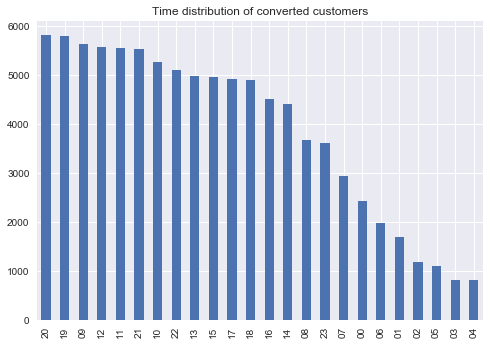

In [32]:
x.value_counts().plot.bar()
plt.title('Time distribution of converted customers')

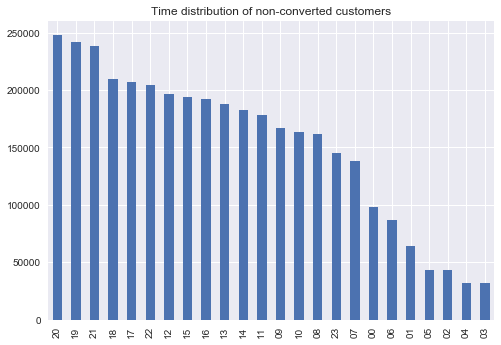

In [33]:
# 查看非转化用户的
df_train[df_train.label == 0].clickTime.astype(str).str[2:4].value_counts().plot.bar()
plt.title('Time distribution of non-converted customers')

### 2.2.2 Heatmap

此 Heatmap 为__初步测试__，没有对 df_train 做任何的处理，此 Heatmap 显示 label 的值和其他特征相关系数很低。

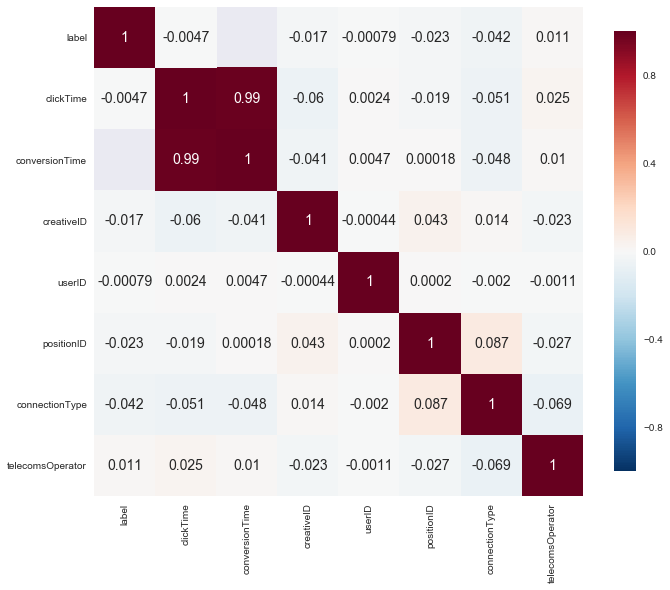

In [34]:
_, ax = plt.subplots(figsize =(11,9))
sns.heatmap(df_train.corr(), vmax=1, 
            annot=True, annot_kws = {'fontsize': 14}, 
            cbar_kws={ 'shrink' : 0.9 },
            square=True, 
            ax=ax)

### 2.2.3 多少 test.csv 里的 user 存在于 train.csv 里

In [35]:
# df_train 里有很多的用户出现了很多次
df_train.userID.value_counts()[:20]

1884671    113
865369     101
2177410     98
674047      86
2453862     79
1429590     71
2655628     71
1927874     68
1168889     68
1002893     65
290299      62
892865      60
1433076     59
962257      58
1192225     58
232920      58
1957083     57
2170983     57
2275498     56
946121      55
Name: userID, dtype: int64

In [36]:
# unique userID in train.csv
print('how many: ', len(df_train.userID.unique()))
print('in: ', len(df_train), '素材s')
uniqueUser_Train = df_train.userID.unique()

how many:  2595627
in:  3749528 素材s


In [37]:
uniqueUser_Test = df_test.userID.unique()

In [38]:
## 比较慢的算法，暂时不用
# testUserID_inTrain = []
# uniqueUser_Test = df_test.userID.unique()
# for i in uniqueUser_Test:
#     if i in uniqueUser_Train:
#         testUserID_inTrain.append(i)
# testUserID_inTrain

In [180]:
# 上面的搜索有点慢，这里写了一个改进过的二分搜索，尤其注意是要事先排序
def binary_search(array, guess):
    lo = 0
    hi = len(array) - 1
    counter = 1
    while lo < hi:
        mi = (lo + hi) // 2
        if array[mi] < guess:
            lo = mi + 1
        else:
            hi = mi
        counter += 1
    if array[hi] == guess:
        return True

In [40]:
# 定义需要搜索的列表
testUserID_inTrain = []
uniqueUser_Test_list = uniqueUser_Test.tolist()
uniqueUser_Train_list = uniqueUser_Train.tolist()
uinqueUser_Train_list_sorted = sorted(uniqueUser_Train_list)

In [41]:
# 二分搜索，超级快！
for i in uniqueUser_Test_list:
    if binary_search(uinqueUser_Train_list_sorted, i):
        testUserID_inTrain.append(i)
testUserID_inTrain

[9762,
 2513636,
 1144620,
 1113275,
 1749379,
 840178,
 1945411,
 1789615,
 1884781,
 596931,
 1251533,
 2455848,
 1191158,
 2272417,
 390752,
 1399698,
 2297337,
 2211980,
 165937,
 463724,
 410581,
 760274,
 1724822,
 2122549,
 1352275,
 530184,
 202902,
 1548765,
 2469403,
 608542,
 1921583,
 1766182,
 1054163,
 1560098,
 1890951,
 50843,
 572169,
 633418,
 1454116,
 1007904,
 1569284,
 2077956,
 351992,
 1720175,
 848365,
 92116,
 2005023,
 977115,
 2701308,
 1849494,
 472542,
 323059,
 2343346,
 1375292,
 492080,
 2302589,
 1573394,
 2485217,
 2015849,
 2291312,
 319404,
 886929,
 563813,
 2600333,
 587017,
 236637,
 999953,
 2589753,
 2744641,
 589051,
 133601,
 2648873,
 2531360,
 1715446,
 2108166,
 247961,
 2371656,
 520520,
 501839,
 2466735,
 2578965,
 1798957,
 1938595,
 2426438,
 1610835,
 453418,
 2177949,
 151907,
 1814161,
 1256387,
 631348,
 1337647,
 1519361,
 6492,
 76636,
 765082,
 151825,
 1179337,
 1694478,
 2486833,
 565433,
 2275391,
 951110,
 2158466,
 2000215

In [42]:
# 结果这么多的 User 是在 Train 里的
print('overlap: ', len(testUserID_inTrain))
# 占 test 中 userID 的：
87975 / 297466

overlap:  87975


0.2957480854954852

### 2.2.4 多少 test.csv 里的 user 存在于 user.csv 里

In [43]:
testUserID_inUser = []
uniqueUser_User_list = df_user.userID.unique().tolist()

In [44]:
for i in uniqueUser_Test_list:
    if binary_search(uniqueUser_User_list, i):
        testUserID_inUser.append(i)
testUserID_inUser

[1164848,
 2127247,
 2769125,
 9762,
 2513636,
 488035,
 225561,
 1144620,
 1113275,
 1361729,
 1749379,
 840178,
 1945411,
 1789615,
 340733,
 1884781,
 596931,
 931181,
 2657412,
 1251533,
 1199429,
 2455848,
 1956857,
 1191158,
 2272417,
 390752,
 1399698,
 2297337,
 1423913,
 1206944,
 2211980,
 1504817,
 121959,
 165937,
 1266100,
 463724,
 410581,
 740082,
 2476730,
 2682829,
 1214260,
 2396848,
 1215329,
 2804635,
 1676799,
 760274,
 2035756,
 1724822,
 2122549,
 1352275,
 1622025,
 530184,
 1709888,
 202902,
 2051190,
 218766,
 1548765,
 2469403,
 2294169,
 2135399,
 2495709,
 2728503,
 213539,
 608542,
 1921583,
 2306612,
 1539560,
 1766182,
 1054163,
 2095274,
 485390,
 1560098,
 1362600,
 1890951,
 2088525,
 50843,
 572169,
 633418,
 1454116,
 1007904,
 1569284,
 1305693,
 2077956,
 566396,
 351992,
 2267672,
 1720175,
 2659466,
 848365,
 2646081,
 92116,
 2005023,
 1226385,
 220119,
 173965,
 2650606,
 977115,
 90931,
 2701308,
 2080590,
 1849494,
 463714,
 472542,
 1283924

In [45]:
# test.csv 中 100% 的 userID 在 user.csv 里面
print(len(testUserID_inUser))
print(len(df_test.userID.unique()))

297466
297466


### 2.2.5 每天的转化数量

In [46]:
df_train_addDay = df_train[['label', 'clickTime']]

(array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000.]), <a list of 10 Text yticklabel objects>)

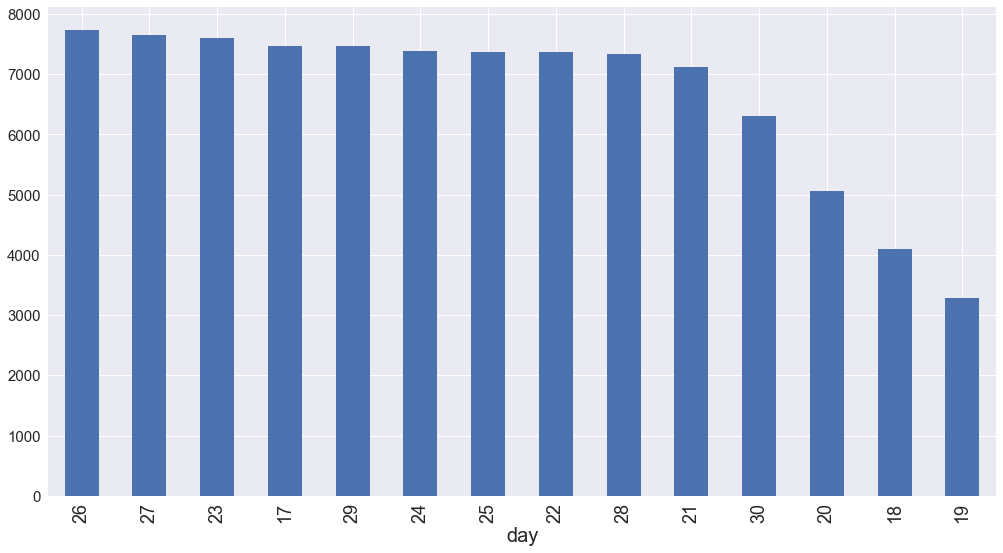

In [47]:
df_train_addDay[df_train_addDay['label']==1].clickTime.astype(str).str[:2].value_counts().plot.bar(figsize=(17,9))
plt.xlabel('day', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=15)

### 2.2.6 关于 convertionTime

In [48]:
df_train.conversionTime.mean()

242645.35801290986

In [49]:
df_train[df_train.conversionTime.isnull() == False].conversionTime.tolist()

[181031.0,
 170009.0,
 170010.0,
 181027.0,
 181031.0,
 181031.0,
 181025.0,
 181031.0,
 181028.0,
 170010.0,
 170015.0,
 181030.0,
 181027.0,
 170005.0,
 181027.0,
 181031.0,
 170005.0,
 181026.0,
 170005.0,
 170008.0,
 170005.0,
 170028.0,
 170006.0,
 172016.0,
 170006.0,
 170010.0,
 181030.0,
 170007.0,
 170007.0,
 181029.0,
 181026.0,
 170712.0,
 170006.0,
 170008.0,
 170010.0,
 181026.0,
 170015.0,
 170010.0,
 170009.0,
 170009.0,
 181031.0,
 170010.0,
 181025.0,
 170028.0,
 181032.0,
 181031.0,
 170010.0,
 181026.0,
 170012.0,
 170010.0,
 171621.0,
 170013.0,
 181028.0,
 172008.0,
 181025.0,
 170021.0,
 170024.0,
 181029.0,
 181029.0,
 170014.0,
 170013.0,
 181029.0,
 170014.0,
 170015.0,
 181031.0,
 170015.0,
 181031.0,
 181030.0,
 170015.0,
 181026.0,
 170020.0,
 170100.0,
 170017.0,
 170016.0,
 170017.0,
 170018.0,
 170020.0,
 170022.0,
 181026.0,
 170018.0,
 181026.0,
 170018.0,
 170030.0,
 181025.0,
 170019.0,
 181028.0,
 170020.0,
 170021.0,
 181029.0,
 171546.0,
 170023.0,

In [50]:
scipy.stats.describe(df_train[df_train.conversionTime.isnull() == False].conversionTime.tolist())

DescribeResult(nobs=93262, minmax=(170005.0, 302359.0), mean=242645.35801290986, variance=1543341516.3694718, skewness=-0.21146186364394765, kurtosis=-1.0535621861252564)

In [51]:
# 平均多少天？
# 差不多2天19小时会转化
242645.3580129098 / 3600 / 24

2.808395347371641

In [52]:
# median也差不多
df_train[df_train.conversionTime.isnull() == False].conversionTime.median()

242106.0

### 2.2.6 User 年龄分布

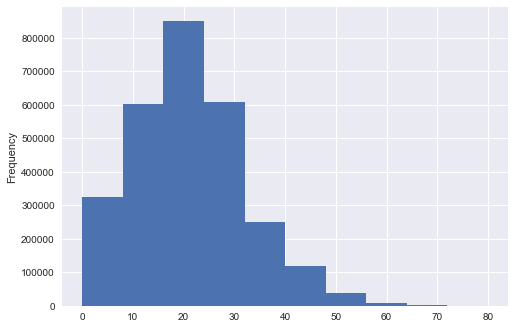

In [88]:
df_user.age.plot.hist()

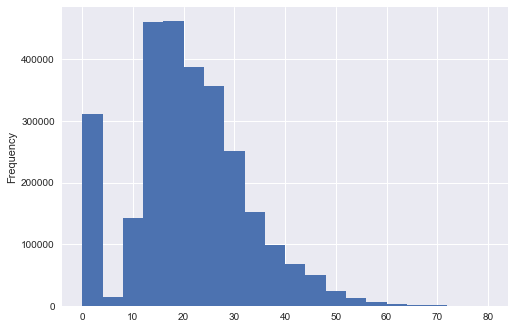

In [89]:
df_user.age.plot.hist(bins=20)

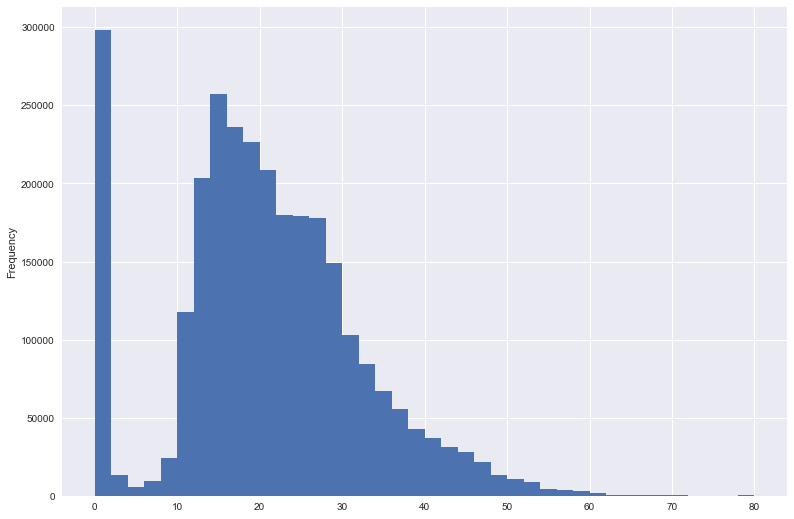

In [91]:
df_user.age.plot.hist(bins=40, figsize=(13,9))

In [35]:
df_user.age.value_counts()[:10]

0     294271
15    150175
16    120322
17    115704
19    115692
13    114651
20    112301
18    110549
14    107356
25     99378
Name: age, dtype: int64

### 2.2.7 User 的 residence 分布

In [36]:
df_user.residence.value_counts()[:10]

0       226812
1901     54518
206      40968
401      37751
2301     36581
201      36516
2601     36245
2201     31458
209      30947
503      29439
Name: residence, dtype: int64

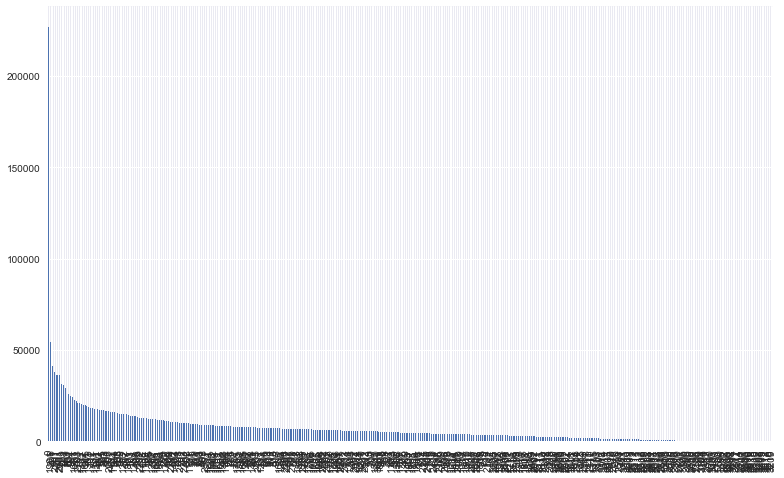

In [96]:
df_user.residence.value_counts().plot.bar(figsize=(13,8))

In [100]:
pd.DataFrame(df_user.residence.value_counts()).describe()

,residence
count,400.000000
mean,7012.795000
std,13116.465534
min,1.000000
25%,1646.500000
50%,4677.500000
75%,8233.500000
max,226812.000000


In [101]:
pd.DataFrame(df_user.residence.value_counts()[1:]).describe()

,residence
count,399.000000
mean,6461.919799
std,7126.257823
min,1.000000
25%,1640.000000
50%,4676.000000
75%,8199.000000
max,54518.000000


### 2.2.8 引入 User 安装 app 数量和 app_category 数量的表格

In [42]:
df_appfeatures=pd.merge(df_user_installedapps,df_app_categories,how='left',on='appID')

In [52]:
df_appfeatures.head()

,userID,appID,appCategory
0,1,357,201
1,1,360,201
2,1,362,409
3,1,365,301
4,1,375,203


In [ ]:
tmp = df_appfeatures

In [63]:
tmp = pd.DataFrame(df_appfeatures.groupby('userID')['appID'].count())

In [66]:
tmp['userID'] = tmp.index

In [68]:
tmp.index=range(len(tmp))

In [70]:
tmp = tmp[['userID','appID']]

In [80]:
tmp.columns = ['userID', 'appNum']

In [81]:
tmp.head()

,userID,appNum
0,1,79
1,9,3
2,10,97
3,12,38
4,14,62


In [82]:
# 用这个merge
df_appNum = tmp

In [73]:
df_appfeatures.groupby('userID').appCategory.value_counts()

userID   appCategory
1        0              37
         201             9
         301             8
         503             8
         203             5
         407             3
         108             2
         409             2
         103             1
         209             1
         211             1
         402             1
         406             1
9        210             1
         301             1
         503             1
10       0              46
         503            18
         301             7
         201             5
         405             4
         407             4
         402             3
         403             3
         203             2
         2               1
         103             1
         106             1
         209             1
         408             1
                        ..
2805107  106             2
         401             2
         407             2
         103             1
2805111  0              19
       

In [75]:
ttp = pd.DataFrame(df_appfeatures.groupby('userID').appCategory.value_counts())

In [77]:
ttp.head()

appCategory
userID appCategory             
1      0                     37
       201                    9
       301                    8
       503                    8
       203                    5

### 2.2.9 User 平均安装时间

In [92]:
tmp = pd.DataFrame(df_user_appactions.groupby('userID').installTime.mean())

In [94]:
tmp['userID'] = tmp.index
tmp.index = range(len(tmp))
tmp = tmp[['userID','installTime']]
tmp.columns = ['userID', 'meanInstallTime']

In [102]:
len(tmp)

781112

In [96]:
tmp.head()

,userID,meanInstallTime
0,1,182032.000000
1,5,257869.555556
2,12,117793.750000
3,14,81498.714286
4,19,21921.000000


In [97]:
df_installTime = tmp

### 2.2.10 提取对比所有feature

In [36]:
df_all_train = pd.merge(df_train,df_user, how='left', on='userID')
df_all_train = pd.merge(df_all_train, df_ad, how='left', on='creativeID')
df_all_train = pd.merge(df_all_train, df_app_categories, how='left', on='appID')
df_all_train = pd.merge(df_all_train, df_position, how='left', on='positionID')
df_all_train = pd.merge(df_all_train, df_appNum, how='left', on='userID')
df_all_train = pd.merge(df_all_train, df_installTime, how='left', on='userID')
df_all_train = pd.merge(df_all_train, ageGroup_forMerge, how='left', on='age')
df_all_train = pd.merge(df_all_train, tmp, how='left', on='residence')

NameError: name 'df_appNum' is not defined

In [ ]:
df_all_test = pd.merge(df_test,df_user, how='left', on='userID')
df_all_test = pd.merge(df_all_test, df_ad, how='left', on='creativeID')
df_all_test = pd.merge(df_all_test, df_app_categories, how='left', on='appID')
df_all_test = pd.merge(df_all_test, df_position, how='left', on='positionID')
df_all_test = pd.merge(df_all_test, df_appNum, how='left', on='userID')
df_all_test = pd.merge(df_all_test, df_installTime, how='left', on='userID')
df_all_test = pd.merge(df_all_test, ageGroup_forMerge, how='left', on='age')
df_all_test = pd.merge(df_all_test, tmp, how='left', on='residence')

In [118]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749528 entries, 0 to 3749527
Data columns (total 27 columns):
label               int64
clickTime           int64
conversionTime      float64
creativeID          int64
userID              int64
positionID          int64
connectionType      int64
telecomsOperator    int64
age                 int64
gender              int64
education           int64
marriageStatus      int64
haveBaby            int64
hometown            int64
residence           int64
adID                int64
camgaignID          int64
advertiserID        int64
appID               int64
appPlatform         int64
appCategory         int64
sitesetID           int64
positionType        int64
appNum              float64
meanInstallTime     float64
ageGroup            int64
residenceGroup      int64
dtypes: float64(3), int64(24)
memory usage: 801.0 MB


In [119]:
df_all_train.describe()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,...,advertiserID,appID,appPlatform,appCategory,sitesetID,positionType,appNum,meanInstallTime,ageGroup,residenceGroup
count,3.749528e+06,3.749528e+06,93262.000000,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,...,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,1.951960e+06,1.048665e+06,3.749528e+06,3.749528e+06
mean,2.487300e-02,2.418317e+05,242645.358013,3.261575e+03,1.405349e+06,3.702799e+03,1.222590e+00,1.605879e+00,2.011426e+01,1.284243e+00,...,2.776200e+01,3.703212e+02,1.217947e+00,1.819372e+02,2.934479e-01,8.044047e-01,5.773160e+01,1.519507e+05,3.646471e+00,3.122679e+00
std,1.557380e-01,3.958793e+04,39285.385532,1.829643e+03,8.088094e+05,1.923724e+03,5.744428e-01,8.491127e-01,1.187724e+01,6.597284e-01,...,3.274570e+01,1.440570e+02,4.128515e-01,1.032034e+02,4.718961e-01,6.385933e-01,2.716201e+01,7.331466e+04,2.192209e+00,1.249161e+00
min,0.000000e+00,1.700000e+05,170005.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.116270e+05,211626.000000,1.540000e+03,7.058698e+05,2.579000e+03,1.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,...,3.000000e+00,3.600000e+02,1.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,4.000000e+01,1.011365e+05,2.000000e+00,3.000000e+00
50%,0.000000e+00,2.418390e+05,242106.000000,3.465000e+03,1.407062e+06,3.322000e+03,1.000000e+00,1.000000e+00,1.900000e+01,1.000000e+00,...,3.000000e+00,4.650000e+02,1.000000e+00,2.090000e+02,0.000000e+00,1.000000e+00,5.500000e+01,1.465119e+05,3.000000e+00,4.000000e+00
75%,0.000000e+00,2.722170e+05,272344.000000,4.565000e+03,2.105989e+06,4.896000e+03,1.000000e+00,2.000000e+00,2.700000e+01,2.000000e+00,...,5.600000e+01,4.650000e+02,1.000000e+00,2.090000e+02,1.000000e+00,1.000000e+00,7.200000e+01,2.069365e+05,5.000000e+00,4.000000e+00
max,1.000000e+00,3.023590e+05,302359.000000,6.582000e+03,2.805118e+06,7.645000e+03,4.000000e+00,3.000000e+00,8.000000e+01,2.000000e+00,...,9.100000e+01,4.720000e+02,2.000000e+00,5.030000e+02,2.000000e+00,5.000000e+00,5.050000e+02,3.023590e+05,9.000000e+00,4.000000e+00


有缺失数据

In [120]:
df_all_train.head()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,...,advertiserID,appID,appPlatform,appCategory,sitesetID,positionType,appNum,meanInstallTime,ageGroup,residenceGroup
0,0,170000,NaN,3089,2798058,293,1,1,25,2,...,10,434,1,108,0,3,44.0,NaN,5,4
1,0,170000,NaN,1259,463234,6161,1,2,20,2,...,80,14,2,2,0,1,NaN,NaN,4,4
2,0,170000,NaN,4465,1857485,7434,4,1,16,1,...,3,465,1,209,0,1,NaN,NaN,3,3
3,0,170000,NaN,1004,2038823,977,1,1,0,0,...,3,465,1,209,0,1,69.0,141609.285714,0,4
4,0,170000,NaN,1887,2015141,3688,1,1,35,1,...,84,360,1,201,0,1,NaN,170107.000000,7,4


In [121]:
df_all_train.columns

Index(['label', 'clickTime', 'conversionTime', 'creativeID', 'userID',
       'positionID', 'connectionType', 'telecomsOperator', 'age', 'gender',
       'education', 'marriageStatus', 'haveBaby', 'hometown', 'residence',
       'adID', 'camgaignID', 'advertiserID', 'appID', 'appPlatform',
       'appCategory', 'sitesetID', 'positionType', 'appNum', 'meanInstallTime',
       'ageGroup', 'residenceGroup'],
      dtype='object')

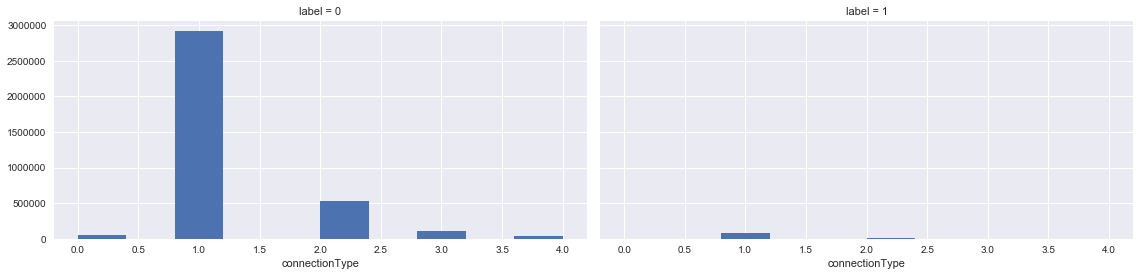

In [129]:
# graphs
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'connectionType')

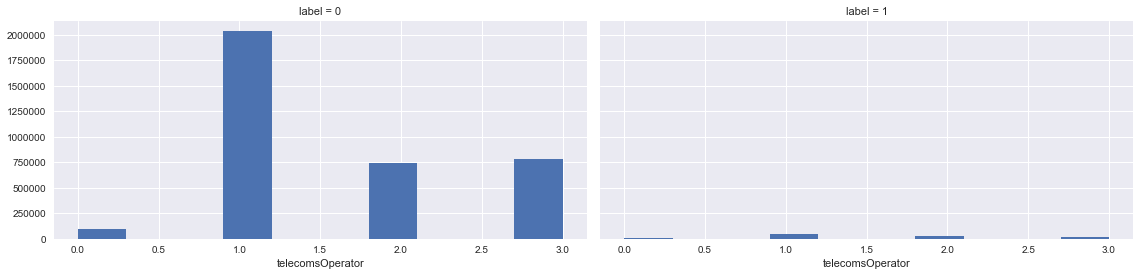

In [130]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'telecomsOperator')

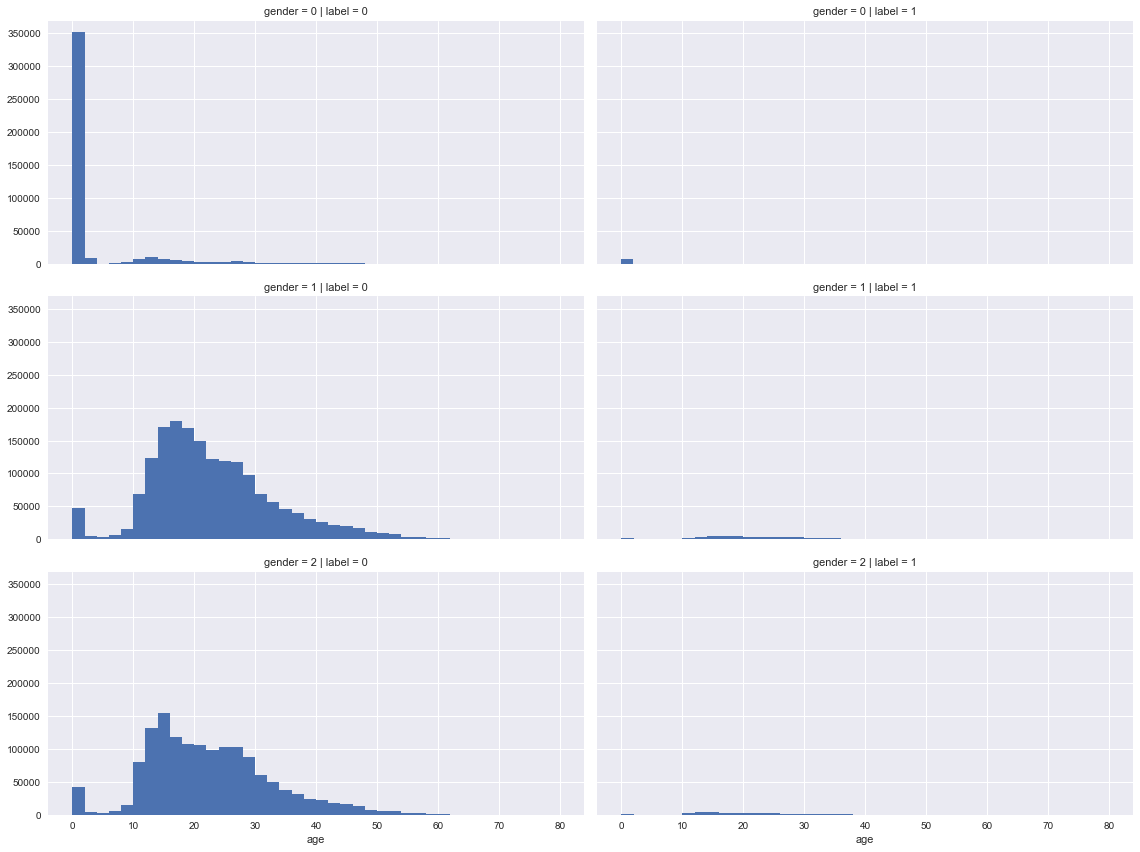

In [110]:
sns.FacetGrid(df_all_train, col='label', row='gender',size=4, aspect=2)\
   .map(plt.hist, 'age', bins=40)

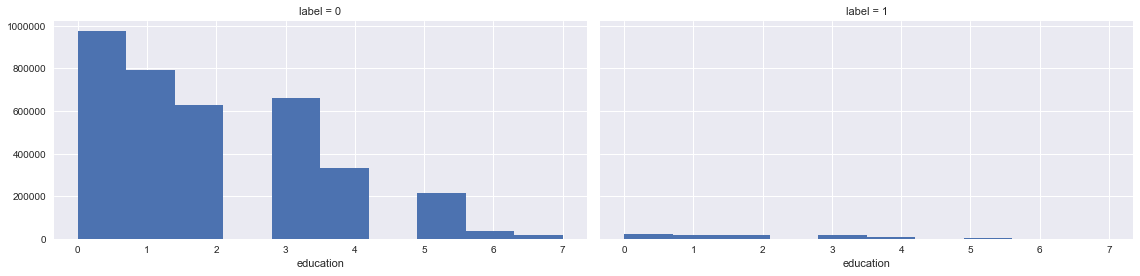

In [134]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'education')

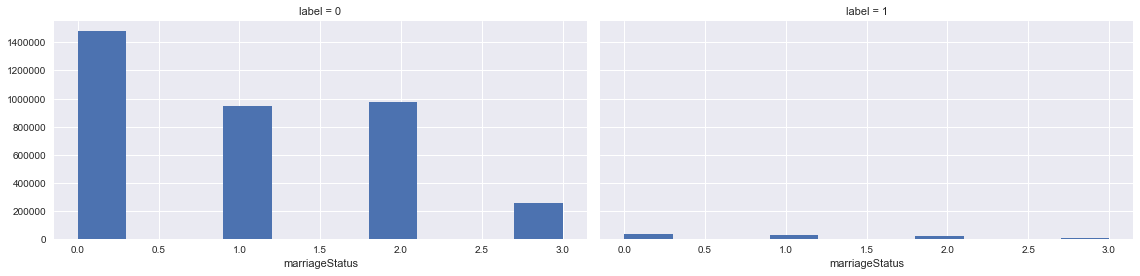

In [133]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'marriageStatus')

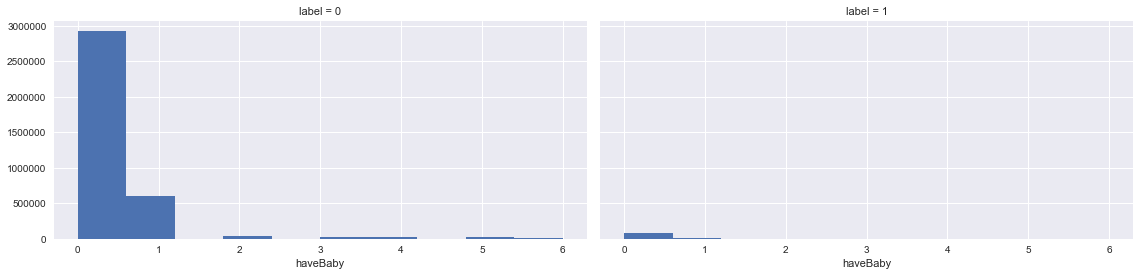

In [135]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'haveBaby')

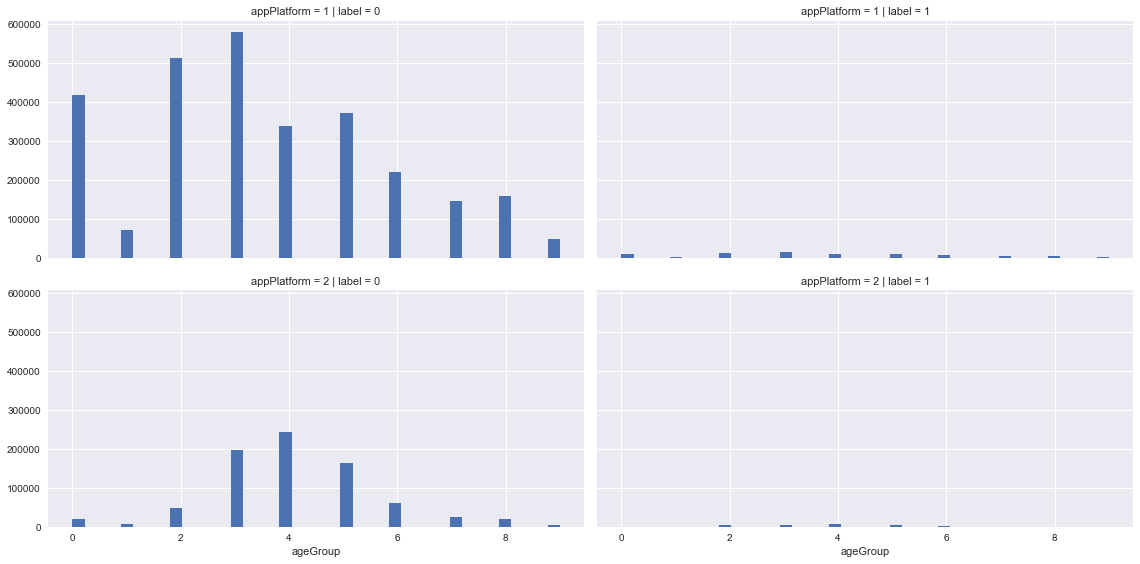

In [137]:
sns.FacetGrid(df_all_train, col='label', row='appPlatform',size=4, aspect=2)\
   .map(plt.hist, 'ageGroup', bins=40)

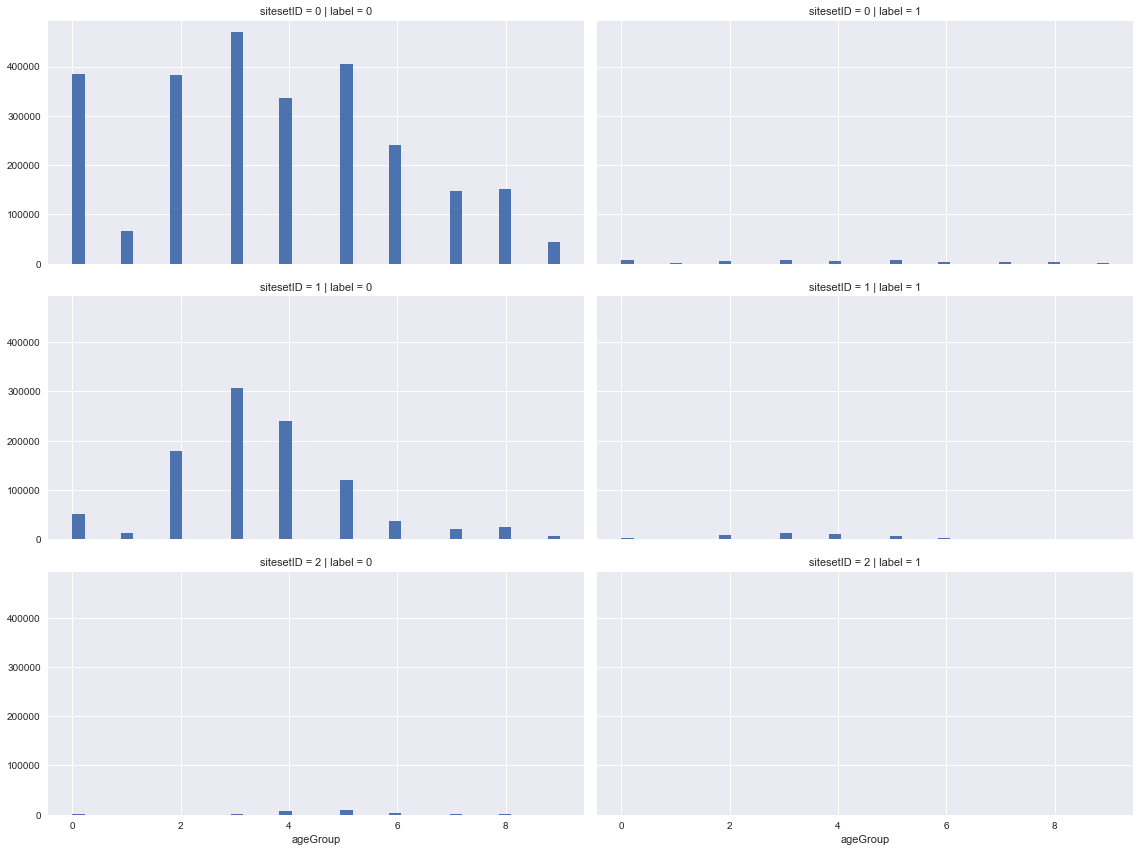

In [125]:
sns.FacetGrid(df_all_train, col='label', row='sitesetID',size=4, aspect=2)\
   .map(plt.hist, 'ageGroup', bins=40)

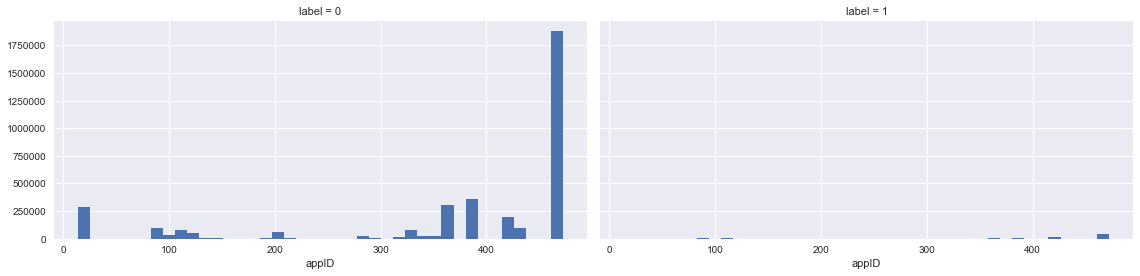

In [138]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'appID', bins=40)

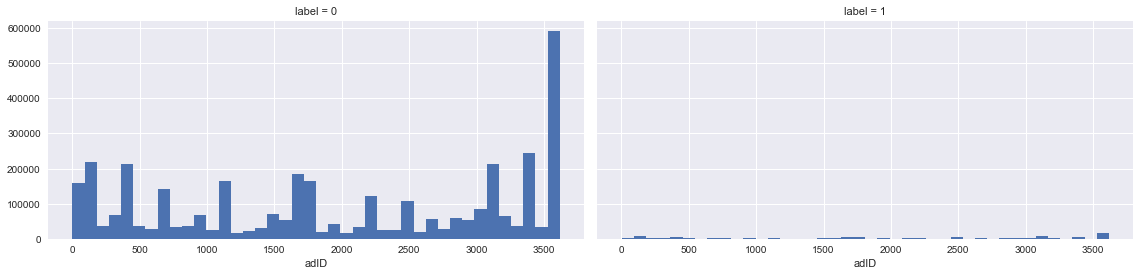

In [151]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'adID', bins=40)

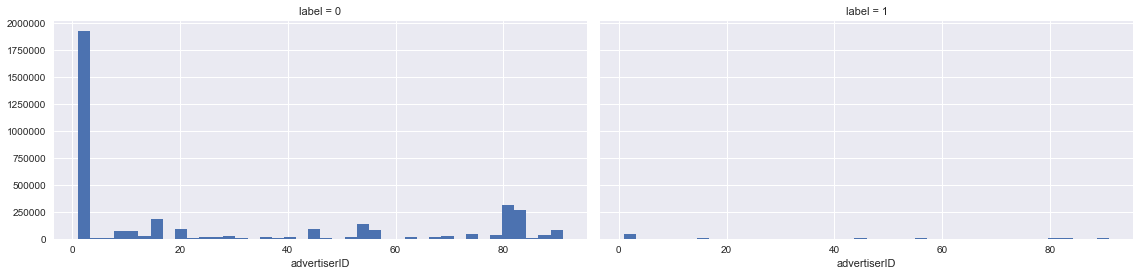

In [140]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'advertiserID', bins=40)

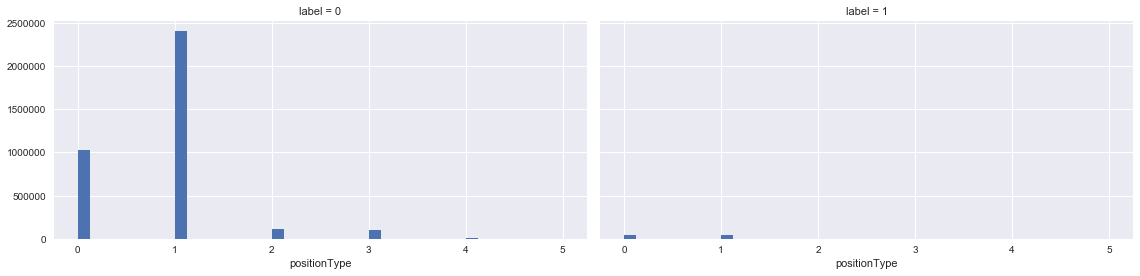

In [141]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'positionType', bins=40)

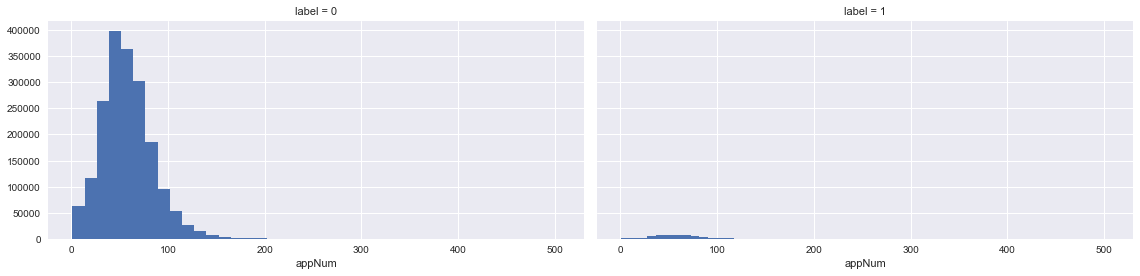

In [142]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'appNum', bins=40)

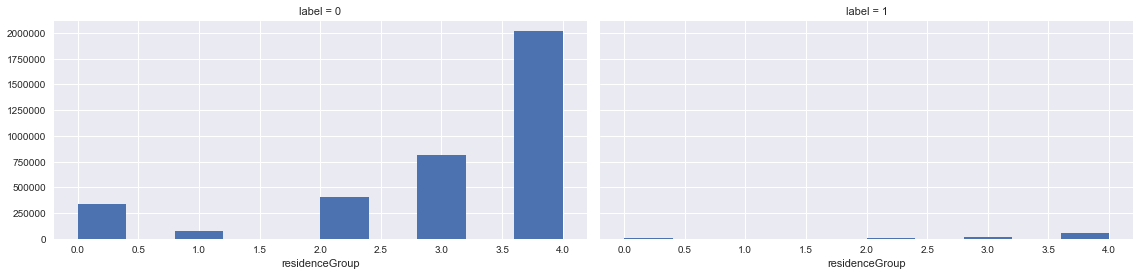

In [147]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'residenceGroup')

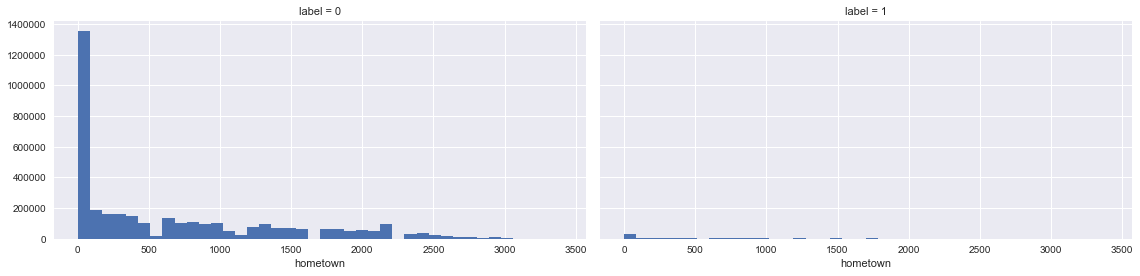

In [148]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(plt.hist, 'hometown', bins=40)

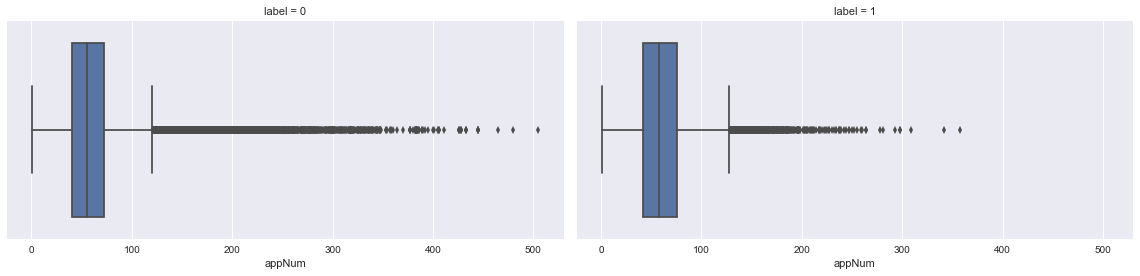

In [144]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(sns.boxplot, 'appNum')

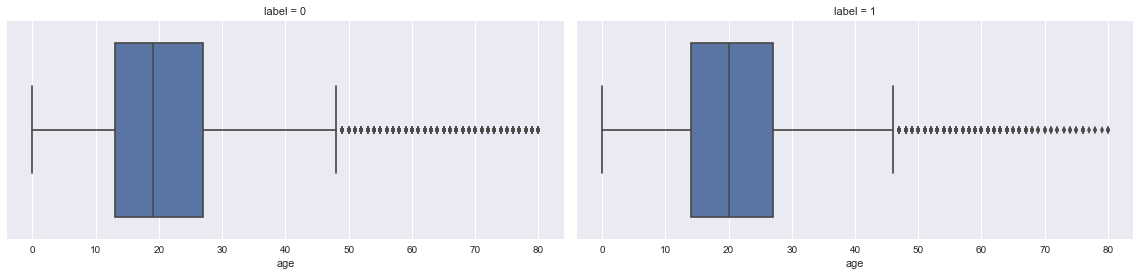

In [146]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(sns.boxplot, 'age')

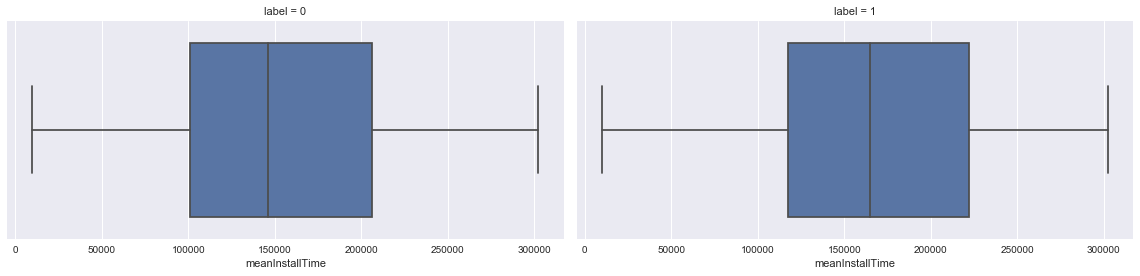

In [150]:
sns.FacetGrid(df_all_train, col='label',size=4, aspect=2)\
   .map(sns.boxplot, 'meanInstallTime')

In [184]:
# 看看 label=1 有哪些特征
train_label_1 = df_all_train[df_all_train['label'] == 1]
train_label_1.index = range(len(train_label_1))
train_label_1.head(2)

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,...,advertiserID,appID,appPlatform,appCategory,sitesetID,positionType,appNum,meanInstallTime,ageGroup,residenceGroup
0,1,170001,181031.0,2137,703736,2579,1,1,29,1,...,84,360,1,201,1,0,NaN,170248.0,5,2
1,1,170001,170009.0,3981,2030308,2579,2,1,20,2,...,44,421,1,104,1,0,79.0,247080.0,4,4


In [154]:
# export to csv
df_all_train[df_all_train['label'] == 1].to_csv('train-label-1.csv')

In [191]:
tpp = []
tpp1 = train_label_1.userID.unique().tolist()
tpp2 = df_test.userID.unique().tolist()

In [193]:
# train里label=1的在test里一个都没有
for i in tpp1:
    if binary_search(tpp2,i):
        tpp.append(i)
len(tpp)

0

### 2.2.11 看user点与不点

In [175]:
df_all_train.groupby('userID').label.sum().sort_values(ascending=False)

userID
2676800    11
1511544     7
979819      6
201873      6
1027751     6
171368      5
993120      4
1950566     4
907063      4
2699021     4
1483605     4
438307      4
1184533     4
1432913     4
1138040     4
391035      3
2464540     3
475046      3
917466      3
990225      3
2340514     3
2248895     3
43578       3
186417      3
12619       3
1497645     3
1816356     3
1177344     3
474179      3
731719      3
           ..
1853048     0
1853047     0
1853046     0
1853045     0
1853044     0
1853043     0
1853041     0
1853040     0
1853038     0
1853037     0
1853054     0
1853056     0
1853073     0
1853057     0
1853072     0
1853071     0
1853070     0
1853069     0
1853068     0
1853067     0
1853066     0
1853065     0
1853064     0
1853063     0
1853062     0
1853061     0
1853060     0
1853059     0
1853058     0
1           0
Name: label, dtype: int64

In [158]:
5 in df_test.userID

True

In [176]:
2676800 in df_test.userID

False

In [179]:
1511544 in df_test.userID

False

In [194]:
979819 in df_test.userID

False

In [177]:
df_all_train[df_all_train['userID'] == 2676800]

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,...,advertiserID,appID,appPlatform,appCategory,sitesetID,positionType,appNum,meanInstallTime,ageGroup,residenceGroup
1440194,1,230718,230719.0,3916,2676800,6315,1,3,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1454414,1,230822,230823.0,6342,2676800,1153,1,3,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1487497,1,231101,231103.0,6239,2676800,6005,1,3,17,2,...,54,389,1,108,0,3,49.0,162079.727273,3,4
1514549,1,231245,231245.0,542,2676800,6315,1,1,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1534005,1,231404,231404.0,6342,2676800,6315,1,1,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1602375,0,231854,NaN,6239,2676800,6005,1,3,17,2,...,54,389,1,108,0,3,49.0,162079.727273,3,4
1659725,0,232154,NaN,1004,2676800,3365,1,3,17,2,...,3,465,1,209,0,1,49.0,162079.727273,3,4
1800399,1,241336,241347.0,3489,2676800,1848,1,1,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1834310,1,241606,241606.0,350,2676800,1153,1,1,17,2,...,54,389,1,108,0,1,49.0,162079.727273,3,4
1894773,1,241940,242003.0,5598,2676800,6005,1,1,17,2,...,54,389,1,108,0,3,49.0,162079.727273,3,4


In [178]:
df_all_train[df_all_train['userID'] == 1511544] 

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,...,advertiserID,appID,appPlatform,appCategory,sitesetID,positionType,appNum,meanInstallTime,ageGroup,residenceGroup
3398208,1,292244,292305.0,665,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3461923,1,300850,300850.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3462128,1,300851,301105.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3498521,1,301122,301125.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3499502,0,301125,NaN,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3500922,1,301130,301131.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3501094,0,301131,NaN,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3597329,1,301658,301658.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4
3599917,1,301705,301754.0,615,1511544,2150,1,3,0,0,...,89,420,1,402,1,0,23.0,292304.0,0,4


In [170]:
df_all_train[df_all_train['label'] == 1].userID.count()

93262

In [171]:
len(df_all_train[df_all_train['label'] == 1].userID.unique())
# 有1000个user安了不止一个app的案例

92051

### 2.2.12 集合在素材、广告、活动、还是公司？

In [196]:
df_creaUnderAd=pd.DataFrame({"NumOfCrea_ad" : df_ad[["creativeID","adID"]].groupby(["adID"]).size()}).reset_index()
df_creaUnderAd.head()

,adID,NumOfCrea_ad
0,1,3
1,2,3
2,3,2
3,4,1
4,5,1


In [217]:
df_creaUnderCamp=pd.DataFrame({"NumOfCrea_camp" : df_ad[["creativeID","camgaignID"]].groupby(["camgaignID"]).size()}).reset_index()
df_creaUnderCamp.head()

,camgaignID,NumOfCrea_camp
0,1,8
1,2,21
2,3,1
3,4,1
4,5,4


In [197]:
df_creaUnderAdvertiser=pd.DataFrame({"NumOfCrea_advertiser": df_ad[["creativeID","advertiserID"]].groupby(["advertiserID"]).size()}).reset_index()
df_creaUnderAdvertiser.head()

,advertiserID,NumOfCrea_advertiser
0,1,5
1,2,78
2,3,56
3,4,4
4,5,1


In [198]:
df_creaUnderApp=pd.DataFrame({"NumOfCrea_app": df_ad[["creativeID","appID"]].groupby(["appID"]).size()}).reset_index()
df_creaUnderApp.head()

,appID,NumOfCrea_app
0,14,191
1,25,10
2,68,15
3,75,11
4,83,6


In [207]:
## 素材做多的 app
df_creaUnderApp.sort_values(by='NumOfCrea_app',ascending=False)[:20]

,appID,NumOfCrea_app
40,389,1400
46,434,803
44,421,763
12,123,713
29,286,514
34,328,239
26,278,199
41,391,193
0,14,191
38,360,146


In [208]:
# label=1 里最多的 app
train_label_1.groupby('appID').userID.size().sort_values(ascending=False)[:20]

appID
465    38962
360     9896
421     7445
109     6797
383     6696
420     5693
428     1587
84      1571
198     1470
389     1400
328     1339
286     1285
100     1223
319     1106
83      1094
123      998
116      786
14       718
336      416
205      399
dtype: int64

In [209]:
# label=0 素材最多的app
df_all_train[df_all_train['label'] == 0].groupby('appID').userID.size().sort_values(ascending=False)[:20]

appID
465    1877684
360     304286
14      284734
383     186585
421     148085
389     137888
84       81273
328      79001
434      71954
116      50216
420      45293
198      44887
123      41372
100      38414
391      34345
336      28841
356      28662
109      26567
428      24152
319      20768
dtype: int64

In [210]:
## 最多素材的 ad
df_creaUnderAd.sort_values(by='NumOfCrea_ad',ascending=False)[:20]

,adID,NumOfCrea_ad
3304,3305,13
2452,2453,7
1934,1935,6
2419,2420,6
2007,2008,5
375,376,5
1464,1465,5
129,130,5
2808,2809,5
3259,3260,5


In [211]:
# label=1 里最多的 ad
train_label_1.groupby('adID').userID.size().sort_values(ascending=False)[:20]

adID
3593    15023
3102     5245
3379     4847
1638     3105
411      3055
2480     2622
1161     2608
1741     2526
170      2520
761      2251
147      1966
86       1908
1778     1840
2238     1816
293      1742
3089     1692
2848     1622
2924     1494
160      1393
2698     1177
dtype: int64

In [212]:
# label=0 素材最多的app
df_all_train[df_all_train['label'] == 0].groupby('adID').userID.size().sort_values(ascending=False)[:20]

adID
3593    581324
3379    197880
411     186228
1638    150961
1161    120029
147     118668
3102    118546
1778    114587
86      113619
2238     89792
696      76778
2519     57902
293      54691
3003     42629
170      40829
1597     38665
1502     36010
677      31256
3084     27854
3347     25620
dtype: int64

In [213]:
## 素材最多的公司
df_creaUnderAdvertiser.sort_values(by='NumOfCrea_advertiser',ascending=False)[:20]

,advertiserID,NumOfCrea_advertiser
53,54,1400
9,10,803
28,29,403
56,57,381
43,44,308
39,40,193
78,79,193
79,80,191
25,26,161
55,56,160


In [214]:
# label=1 里最多的公司
train_label_1.groupby('advertiserID').userID.size().sort_values(ascending=False)[:20]

advertiserID
3     38962
84     9619
81     6797
15     6696
89     5693
57     3749
44     3659
2      1955
69     1587
20     1489
54     1400
75     1094
29     1043
74     1003
91      979
56      906
80      718
8       592
22      514
87      444
dtype: int64

In [215]:
# label=0 里最多地公司
df_all_train[df_all_train['label'] == 0].groupby('advertiserID').userID.size().sort_values(ascending=False)[:20]

advertiserID
3     1877684
80     284734
84     264982
15     186585
54     137888
44      93034
20      88620
10      71954
57      53829
8       47207
2       45811
89      45293
79      34345
91      34066
74      33327
87      29568
81      26567
69      24152
13      21334
9       20613
dtype: int64

In [218]:
## 素材最多的活动
df_creaUnderCamp.sort_values(by='NumOfCrea_camp',ascending=False)[:20]

,camgaignID,NumOfCrea_camp
138,139,605
653,654,257
82,83,198
390,391,166
551,552,166
204,205,166
130,131,165
72,73,163
111,112,159
568,569,158


In [219]:
# label=1 里最多的活动
train_label_1.groupby('camgaignID').userID.size().sort_values(ascending=False)[:20]

camgaignID
632    15023
649     5245
411     4847
201     3724
440     3105
564     3055
26      2974
492     2622
45      2608
444     2251
460     1966
503     1908
513     1889
600     1841
642     1840
637     1816
426     1781
82      1742
58      1678
497     1327
dtype: int64

In [220]:
# label=0 里最多的活动
df_all_train[df_all_train['label'] == 0].groupby('camgaignID').userID.size().sort_values(ascending=False)[:20]

camgaignID
632    581324
411    197880
564    186228
440    150961
45     120029
460    118668
649    118546
642    114587
503    113619
637     89792
183     76778
497     75271
205     59325
60      57902
217     55797
82      54691
83      49245
26      48773
166     38665
23      36010
dtype: int64

# 3. 初步模型

## 3.1 Decision Tree

### 3.1.1 构建新的 DataFrame

In [37]:
df_DeciTree_train = pd.merge(df_train,df_user, how='left', on='userID')
df_DeciTree_train = pd.merge(df_DeciTree_train, df_ad, how='left', on='creativeID')
df_DeciTree_train = pd.merge(df_DeciTree_train, df_app_categories, how='left', on='appID')
df_DeciTree_train = pd.merge(df_DeciTree_train, df_position, how='left', on='positionID')
df_DeciTree_train = pd.merge(df_DeciTree_train, df_app_categories, how='left', on='appID')

In [113]:
df_DeciTree_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749528 entries, 0 to 3749527
Data columns (total 24 columns):
label               int64
clickTime           int64
conversionTime      float64
creativeID          int64
userID              int64
positionID          int64
connectionType      int64
telecomsOperator    int64
age                 int64
gender              int64
education           int64
marriageStatus      int64
haveBaby            int64
hometown            int64
residence           int64
adID                int64
camgaignID          int64
advertiserID        int64
appID               int64
appPlatform         int64
appCategory_x       int64
sitesetID           int64
positionType        int64
appCategory_y       int64
dtypes: float64(1), int64(23)
memory usage: 715.2 MB


In [108]:
df_DeciTree_train.describe()

,label,clickTime,conversionTime,creativeID,userID,positionID,connectionType,telecomsOperator,age,gender,education,marriageStatus,haveBaby,hometown,residence,adID,camgaignID,advertiserID,appID,appPlatform
count,3.749528e+06,3.749528e+06,93262.000000,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06
mean,2.487300e-02,2.418317e+05,242645.358013,3.261575e+03,1.405349e+06,3.702799e+03,1.222590e+00,1.605879e+00,2.011426e+01,1.284243e+00,1.853119e+00,9.999565e-01,2.899181e-01,6.590767e+02,9.630948e+02,2.005435e+03,4.155907e+02,2.776200e+01,3.703212e+02,1.217947e+00
std,1.557380e-01,3.958793e+04,39285.385532,1.829643e+03,8.088094e+05,1.923724e+03,5.744428e-01,8.491127e-01,1.187724e+01,6.597284e-01,1.612715e+00,9.735622e-01,7.716473e-01,7.743070e+02,7.980030e+02,1.250836e+03,2.134300e+02,3.274570e+01,1.440570e+02,4.128515e-01
min,0.000000e+00,1.700000e+05,170005.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,1.000000e+00
25%,0.000000e+00,2.116270e+05,211626.000000,1.540000e+03,7.058698e+05,2.579000e+03,1.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.010000e+02,7.610000e+02,2.050000e+02,3.000000e+00,3.600000e+02,1.000000e+00
50%,0.000000e+00,2.418390e+05,242106.000000,3.465000e+03,1.407062e+06,3.322000e+03,1.000000e+00,1.000000e+00,1.900000e+01,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,3.120000e+02,8.010000e+02,1.977000e+03,4.600000e+02,3.000000e+00,4.650000e+02,1.000000e+00
75%,0.000000e+00,2.722170e+05,272344.000000,4.565000e+03,2.105989e+06,4.896000e+03,1.000000e+00,2.000000e+00,2.700000e+01,2.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,1.111000e+03,1.512000e+03,3.242000e+03,6.320000e+02,5.600000e+01,4.650000e+02,1.000000e+00
max,1.000000e+00,3.023590e+05,302359.000000,6.582000e+03,2.805118e+06,7.645000e+03,4.000000e+00,3.000000e+00,8.000000e+01,2.000000e+00,7.000000e+00,3.000000e+00,6.000000e+00,3.401000e+03,3.401000e+03,3.616000e+03,7.200000e+02,9.100000e+01,4.720000e+02,2.000000e+00


In [114]:
df_DeciTree_train.columns

Index(['label', 'clickTime', 'conversionTime', 'creativeID', 'userID',
       'positionID', 'connectionType', 'telecomsOperator', 'age', 'gender',
       'education', 'marriageStatus', 'haveBaby', 'hometown', 'residence',
       'adID', 'camgaignID', 'advertiserID', 'appID', 'appPlatform',
       'appCategory_x', 'sitesetID', 'positionType', 'appCategory_y'],
      dtype='object')

In [38]:
# 删除不需要的 columns
df_DeciTree_train.drop(df_DeciTree_train.columns[[2,3,4,5,12,13,15,16,20,23]],axis=1,inplace=True)

In [39]:
df_DeciTree_train.columns

Index(['label', 'clickTime', 'connectionType', 'telecomsOperator', 'age',
       'gender', 'education', 'marriageStatus', 'residence', 'advertiserID',
       'appID', 'appPlatform', 'sitesetID', 'positionType'],
      dtype='object')

In [40]:
df_DeciTree_train.sample(5)

,label,clickTime,connectionType,telecomsOperator,age,gender,education,marriageStatus,residence,advertiserID,appID,appPlatform,sitesetID,positionType
1405306,0,230035,1,1,21,2,1,1,1702,80,14,2,0,2
2167220,0,251916,1,3,15,2,3,0,1702,84,360,1,1,0
1959811,0,242254,1,1,0,0,0,2,0,3,465,1,0,1
1810664,0,241425,0,3,30,1,1,0,206,17,205,2,0,1
3436893,0,300608,3,1,0,1,0,2,2601,3,465,1,0,1


### 3.1.2 分组 age 和 residence

In [41]:
# age to groups
ageGroup_forMerge = pd.DataFrame(df_all_train.age.unique(),columns=[['age']])

In [42]:
ageGroup_forMerge['ageGroup'] = 0
for i in range(len(ageGroup_forMerge)):
    if 1 <= ageGroup_forMerge.age[i] < 10:
        ageGroup_forMerge.set_value(i,'ageGroup', 1)
    elif 10 <= ageGroup_forMerge.age[i] < 15:
        ageGroup_forMerge.set_value(i,'ageGroup', 2)
    elif 15 <= ageGroup_forMerge.age[i] < 20:
        ageGroup_forMerge.set_value(i,'ageGroup', 3)
    elif 20 <= ageGroup_forMerge.age[i] < 25:
        ageGroup_forMerge.set_value(i,'ageGroup', 4)
    elif 25 <= ageGroup_forMerge.age[i] < 30:
        ageGroup_forMerge.set_value(i,'ageGroup', 5)
    elif 30 <= ageGroup_forMerge.age[i] < 35:
        ageGroup_forMerge.set_value(i,'ageGroup', 6)
    elif 35 <= ageGroup_forMerge.age[i] < 40:
        ageGroup_forMerge.set_value(i,'ageGroup', 7)
    elif 40 <= ageGroup_forMerge.age[i] < 50:
        ageGroup_forMerge.set_value(i,'ageGroup', 8)
    elif 50 <= ageGroup_forMerge.age[i] < 200:
        ageGroup_forMerge.set_value(i,'ageGroup', 9)

In [43]:
ageGroup_forMerge.sample(5)

,age,ageGroup
68,75,9
79,70,9
66,80,9
69,68,9
76,69,9


In [44]:
# merge w/ tree
df_DeciTree_train = pd.merge(df_DeciTree_train, ageGroup_forMerge, how='left', on='age')

In [45]:
df_DeciTree_train = df_DeciTree_train.drop('age',1)
df_DeciTree_train.sample(5)

,label,clickTime,connectionType,telecomsOperator,gender,education,marriageStatus,residence,advertiserID,appID,appPlatform,sitesetID,positionType,ageGroup
1415593,0,230220,2,1,1,0,2,512,80,14,2,0,1,6
194818,0,171752,1,2,1,0,0,102,3,465,1,0,1,5
3045479,0,281953,1,1,2,0,2,606,3,465,1,0,1,5
2392582,0,261535,1,1,1,5,0,1601,48,336,2,1,0,3
3566497,0,301527,1,2,0,3,1,204,3,465,1,0,1,0


In [46]:
# residence to residenceGroup
tmp = df_user.residence.value_counts()
tmp = pd.DataFrame(df_user.residence.value_counts())
tmp.columns = [['num']]
tmp['residence'] = tmp.index
tmp['residenceGroup'] = 0
tmp.index = range(0,len(tmp))

for i in range(len(tmp)):
    if 1 <= tmp.num[i] < 1640:
        tmp.set_value(i,'residenceGroup',1)
    elif 1640 <= tmp.num[i] < 4676:
        tmp.set_value(i,'residenceGroup',2)
    elif 4676 <= tmp.num[i] < 8199:
        tmp.set_value(i,'residenceGroup',3)
    elif 8199 <= tmp.num[i] < 200000:
        tmp.set_value(i,'residenceGroup',4)

tmp = tmp.drop('num',1)

In [47]:
df_DeciTree_train = pd.merge(df_DeciTree_train, tmp, how='left', on='residence')

In [48]:
df_DeciTree_train = df_DeciTree_train.drop('residence',1)

In [49]:
# 暂时不考虑 clickTime
df_DeciTree_train = df_DeciTree_train.drop('clickTime',1)

In [50]:
df_DeciTree_train.sample(5)

,label,connectionType,telecomsOperator,gender,education,marriageStatus,advertiserID,appID,appPlatform,sitesetID,positionType,ageGroup,residenceGroup
2960558,0,1,3,2,1,2,89,420,1,0,1,6,0
2162106,0,2,1,0,0,1,3,465,1,0,1,0,3
1515832,0,1,3,1,0,2,3,465,1,0,1,5,4
3202977,0,1,1,1,3,2,84,360,1,1,0,3,3
3451234,0,3,1,1,1,1,8,84,2,1,0,3,1


In [249]:
df_DeciTree_train.columns

Index(['label', 'connectionType', 'telecomsOperator', 'gender', 'education',
       'marriageStatus', 'advertiserID', 'appID', 'appPlatform', 'sitesetID',
       'positionType', 'ageGroup', 'residenceGroup'],
      dtype='object')

### 3.1.3 构建模型

In [136]:
# try with 0-1 = 40:1
# test_train_split
X_train, X_test, Y_train, Y_test = train_test_split(df_DeciTree_train.drop('label',1), df_DeciTree_train.label, test_size=0.25, random_state=1)

In [53]:
len(Y_train)

2812146

In [233]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [234]:
clf.score(X_train,Y_train)

0.97614739775246373

In [235]:
clf.score(X_test,Y_test)

0.97401059546694946

In [237]:
clf.predict_proba(X_train)

array([[ 0.95327103,  0.04672897],
       [ 1.        ,  0.        ],
       [ 0.9764631 ,  0.0235369 ],
       ..., 
       [ 0.94117647,  0.05882353],
       [ 0.99236641,  0.00763359],
       [ 0.98019315,  0.01980685]])

### 3.1.4 构建测试 DataFrame

In [140]:
# 整理 test.csv
df_DeciTree_test = pd.merge(df_test,df_user, how='left', on='userID')
df_DeciTree_test = pd.merge(df_DeciTree_test, df_ad, how='left', on='creativeID')
df_DeciTree_test = pd.merge(df_DeciTree_test, df_app_categories, how='left', on='appID')
df_DeciTree_test = pd.merge(df_DeciTree_test, df_position, how='left', on='positionID')
df_DeciTree_test = pd.merge(df_DeciTree_test, df_app_categories, how='left', on='appID')

In [55]:
df_DeciTree_test.columns

Index(['instanceID', 'label', 'clickTime', 'creativeID', 'userID',
       'positionID', 'connectionType', 'telecomsOperator', 'age', 'gender',
       'education', 'marriageStatus', 'haveBaby', 'hometown', 'residence',
       'adID', 'camgaignID', 'advertiserID', 'appID', 'appPlatform',
       'appCategory_x', 'sitesetID', 'positionType', 'appCategory_y'],
      dtype='object')

In [141]:
df_DeciTree_test.drop(df_DeciTree_test.columns[[1,2,3,4,5,12,13,15,16,20,23]],axis=1,inplace=True)

In [142]:
# ageGroup and residenceGroup
df_DeciTree_test = pd.merge(df_DeciTree_test, ageGroup_forMerge, how='left', on='age')
df_DeciTree_test = df_DeciTree_test.drop('age',1)

df_DeciTree_test = pd.merge(df_DeciTree_test, tmp, how='left', on='residence')
df_DeciTree_test = df_DeciTree_test.drop('residence',1)

In [58]:
df_DeciTree_test.head(5)

,instanceID,connectionType,telecomsOperator,gender,education,marriageStatus,advertiserID,appID,appPlatform,sitesetID,positionType,ageGroup,residenceGroup
0,1,1,3,2,1,0,80,14,2,0,1,5,4
1,2,1,3,2,6,1,80,14,2,0,1,4,4
2,3,2,1,1,0,0,3,465,1,0,1,5,3
3,4,2,3,1,3,3,3,465,1,0,1,4,2
4,5,1,3,2,4,0,80,14,2,0,1,1,4


In [59]:
df_DeciTree_test.columns

Index(['instanceID', 'connectionType', 'telecomsOperator', 'gender',
       'education', 'marriageStatus', 'advertiserID', 'appID', 'appPlatform',
       'sitesetID', 'positionType', 'ageGroup', 'residenceGroup'],
      dtype='object')

### 3.1.5 预测&输出.csv

In [253]:
# predict
deciTree_pred = clf.predict(df_DeciTree_test.drop('instanceID',1))

In [268]:
pd.DataFrame(deciTree_pred,columns=['what']).head(5)

,what
0,0
1,0
2,0
3,0
4,0


In [266]:
pd.DataFrame(deciTree_pred,columns=['what']).what.value_counts()

0    337841
1       648
Name: what, dtype: int64

In [267]:
648/337841

0.0019180620469392406

In [269]:
# 第一列为0的概率
clf.predict_proba(df_DeciTree_test.drop('instanceID',1))

array([[ 1.        ,  0.        ],
       [ 0.96551724,  0.03448276],
       [ 0.9939759 ,  0.0060241 ],
       ..., 
       [ 0.98267327,  0.01732673],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

In [271]:
deciTree_pred_prob = clf.predict_proba(df_DeciTree_test.drop('instanceID',1))

In [278]:
deciTree_pred_prob.shape

(338489, 2)

In [282]:
xxx = [x[1] for x in deciTree_pred_prob]

In [283]:
xxx

[0.0,
 0.034482758620689655,
 0.006024096385542169,
 0.0,
 0.0,
 0.0,
 0.016079632465543645,
 0.0,
 0.0,
 0.022857142857142857,
 0.023719491234101067,
 0.024103178518570724,
 0.0,
 0.020920502092050208,
 0.01444043321299639,
 0.0,
 0.040572792362768499,
 0.0,
 0.0,
 0.021097046413502109,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0020746887966804979,
 0.016666666666666666,
 0.020202020202020204,
 0.0058139534883720929,
 0.019880715705765408,
 0.025316455696202531,
 0.019806852432798179,
 0.0,
 0.0,
 0.0,
 0.02843601895734597,
 0.016079632465543645,
 0.029411764705882353,
 0.029862792574656981,
 0.019607843137254902,
 0.01932367149758454,
 0.0,
 0.0,
 0.067567567567567571,
 0.048387096774193547,
 0.0,
 0.042253521126760563,
 0.0,
 0.0,
 0.058333333333333334,
 0.0066006600660066007,
 0.0,
 0.013333333333333334,
 0.14285714285714285,
 0.0,
 0.0,
 0.03964401294498382,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.040697674418604654,
 0.030592734225621414,
 0.0,
 0.0,
 0.02564102564102564,
 0.0,
 0.0,

In [287]:
df_submision = pd.DataFrame(df_test.instanceID, columns=['instanceID', 'prob'])

In [291]:
df_submision.prob = xxx

In [292]:
df_submision.head(5)

,instanceID,prob
0,1,0.000000
1,2,0.034483
2,3,0.006024
3,4,0.000000
4,5,0.000000


In [297]:
# 输出csv
df_submision.to_csv('submission.csv', index=False)

### 3.1.6 修正

#### 3.1.6.1 使用评估方式代码计算 logloss

In [302]:
train_pred = [x[1] for x in clf.predict_proba(X_train)]

In [304]:
# training 的 logloss
logloss(Y_train, train_pred)

0.091154883253164051

In [305]:
test_pred = [x[1] for x in clf.predict_proba(X_test)]

In [306]:
# validation 的 logloss
logloss(Y_test, test_pred)

0.31028643346025975

#### 3.1.6.2 查看原决策树的 confusion matrix 和参数

In [309]:
## training 的 confusion matrix
# 要使用 0-1 而不是 prob
# 其中第一行和第一列都是 label=0
metrics.confusion_matrix(Y_train, clf.predict(X_train))

array([[2741805,     223],
       [  66854,    3264]])

In [ ]:
# label=1 的 recall：3264/(3264+223) = 0.936

In [312]:
metrics.classification_report(Y_train,clf.predict(X_train))

'             precision    recall  f1-score   support\n\n          0       0.98      1.00      0.99   2742028\n          1       0.94      0.05      0.09     70118\n\navg / total       0.98      0.98      0.97   2812146\n'

In [314]:
(Y_train == 1).sum()

70118

In [315]:
(Y_train == 0).sum()

2742028

In [311]:
## validation 的 confusion matrix
# 要使用 0-1 而不是 prob
metrics.confusion_matrix(Y_test, clf.predict(X_test))

array([[912868,   1370],
       [ 22992,    152]])

In [316]:
# label=1 的 recall：152/(152+1370) = 0.1
# 意味着误分类为0.9

In [313]:
metrics.classification_report(Y_test,clf.predict(X_test))

'             precision    recall  f1-score   support\n\n          0       0.98      1.00      0.99    914238\n          1       0.10      0.01      0.01     23144\n\navg / total       0.95      0.97      0.96    937382\n'

In [317]:
## 查看模型的参数
clf.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')>

In [326]:
# max_depth 是看不到的

#### 3.1.6.3 调整 max_depth 得到新的 tree 再做预测、再提交

In [328]:
## max depth = 3
clf_tree2 = DecisionTreeClassifier(max_depth=3)
clf_tree2.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [329]:
# training
metrics.confusion_matrix(Y_train, clf_tree2.predict(X_train))

array([[2742028,       0],
       [  70118,       0]])

In [330]:
# validation
metrics.confusion_matrix(Y_test, clf_tree2.predict(X_test))

array([[914238,      0],
       [ 23144,      0]])

In [334]:
for i in range(4,30):
    clf_tree_diffDepth = DecisionTreeClassifier(max_depth=i)
    clf_tree_diffDepth.fit(X_train,Y_train)
    print('Decision Tree with max_depth = ', str(i))
    print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_tree_diffDepth.predict(X_train)))
    print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_tree_diffDepth.predict(X_test)))
    print('log loss - training:', logloss(Y_train, [x[1] for x in clf_tree_diffDepth.predict_proba(X_train)]))
    print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_tree_diffDepth.predict_proba(X_test)]))
    print('')

Decision Tree with max_depth =  4
confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.109696968295
log loss - validation: 0.108939841851

Decision Tree with max_depth =  5
confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.107820286238
log loss - validation: 0.107013381121

Decision Tree with max_depth =  6
confusion matrix - training
 [[2742028       0]
 [  70114       4]]
confusion matrix - validation
 [[914237      1]
 [ 23144      0]]
log loss - training: 0.107194498068
log loss - validation: 0.106604254656

Decision Tree with max_depth =  7
confusion matrix - training
 [[2742024       4]
 [  70107      11]]
confusion matrix - validation
 [[914234      4]
 [ 23142      2]]
log loss - training: 0.106301403681
log loss - validation: 0.10586273169

Decision Tree with max_depth 

In [340]:
clf_max7 = DecisionTreeClassifier(max_depth=7)
clf_max7.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [341]:
deciTree_pred_max7 = clf_max7.predict(df_DeciTree_test.drop('instanceID',1))

In [342]:
deciTree_pred_prob_max7 = clf_max7.predict_proba(df_DeciTree_test.drop('instanceID',1))

In [343]:
yyy = [x[1] for x in deciTree_pred_prob_max7]

In [344]:
df_submision = pd.DataFrame(df_test.instanceID, columns=['instanceID', 'prob'])
df_submision.prob = yyy

In [345]:
# 输出csv
df_submision.to_csv('submission.csv', index=False)

In [347]:
metrics.confusion_matrix(Y_test, clf_max7.predict(X_test))

array([[914234,      4],
       [ 23142,      2]])

### 3.1.7 修正2

In [232]:
df_all_train.columns

Index(['label', 'clickTime', 'conversionTime', 'creativeID', 'userID',
       'positionID', 'connectionType', 'telecomsOperator', 'age', 'gender',
       'education', 'marriageStatus', 'haveBaby', 'hometown', 'residence',
       'adID', 'camgaignID', 'advertiserID', 'appID', 'appPlatform',
       'appCategory', 'sitesetID', 'positionType', 'appNum', 'meanInstallTime',
       'ageGroup', 'residenceGroup'],
      dtype='object')

In [235]:
df_DeciTree_revise2 = df_all_train.copy()

In [236]:
# with userID
df_DeciTree_revise2.drop(df_DeciTree_revise2.columns[[1,2,5,8,9,12,13,14,15,17,18,19,24]],axis=1,inplace=True)

In [251]:
df_DeciTree_revise2.describe()

,label,creativeID,userID,connectionType,telecomsOperator,education,marriageStatus,camgaignID,appCategory,sitesetID,positionType,appNum,ageGroup,residenceGroup
count,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06
mean,2.487300e-02,3.261575e+03,1.405349e+06,1.222590e+00,1.605879e+00,1.853119e+00,9.999565e-01,4.155907e+02,1.819372e+02,2.934479e-01,8.044047e-01,5.773160e+01,3.646471e+00,3.122679e+00
std,1.557380e-01,1.829643e+03,8.088094e+05,5.744428e-01,8.491127e-01,1.612715e+00,9.735622e-01,2.134300e+02,1.032034e+02,4.718961e-01,6.385933e-01,1.959788e+01,2.192209e+00,1.249161e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.540000e+03,7.058698e+05,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.050000e+02,1.040000e+02,0.000000e+00,0.000000e+00,5.400000e+01,2.000000e+00,3.000000e+00
50%,0.000000e+00,3.465000e+03,1.407062e+06,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,4.600000e+02,2.090000e+02,0.000000e+00,1.000000e+00,5.773160e+01,3.000000e+00,4.000000e+00
75%,0.000000e+00,4.565000e+03,2.105989e+06,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,6.320000e+02,2.090000e+02,1.000000e+00,1.000000e+00,5.773160e+01,5.000000e+00,4.000000e+00
max,1.000000e+00,6.582000e+03,2.805118e+06,4.000000e+00,3.000000e+00,7.000000e+00,3.000000e+00,7.200000e+02,5.030000e+02,2.000000e+00,5.000000e+00,5.050000e+02,9.000000e+00,4.000000e+00


In [250]:
df_DeciTree_revise2 = df_DeciTree_revise2.fillna(df_DeciTree_revise2.appNum.mean())

In [252]:
# try with 0-1 = 40:1
# test_train_split
X_train, X_test, Y_train, Y_test = train_test_split(df_DeciTree_revise2.drop('label',1), df_DeciTree_revise2.label, test_size=0.20, random_state=9)

In [253]:
for i in range(4,15):
    clf_tree_revise2 = DecisionTreeClassifier(max_depth=i)
    clf_tree_revise2.fit(X_train,Y_train)
    print('Decision Tree with max_depth = ', str(i))
    print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_tree_revise2.predict(X_train)))
    print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_tree_revise2.predict(X_test)))
    print('log loss - training:', logloss(Y_train, [x[1] for x in clf_tree_revise2.predict_proba(X_train)]))
    print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_tree_revise2.predict_proba(X_test)]))
    print('')

Decision Tree with max_depth =  4
confusion matrix - training
 [[2925081       0]
 [  74540       1]]
confusion matrix - validation
 [[731185      0]
 [ 18721      0]]
log loss - training: 0.109172427613
log loss - validation: 0.109539171376

Decision Tree with max_depth =  5
confusion matrix - training
 [[2925081       0]
 [  74536       5]]
confusion matrix - validation
 [[731184      1]
 [ 18719      2]]
log loss - training: 0.10818591705
log loss - validation: 0.108499707357

Decision Tree with max_depth =  6
confusion matrix - training
 [[2925081       0]
 [  74534       7]]
confusion matrix - validation
 [[731183      2]
 [ 18719      2]]
log loss - training: 0.107503360721
log loss - validation: 0.1079005465

Decision Tree with max_depth =  7
confusion matrix - training
 [[2925069      12]
 [  74510      31]]
confusion matrix - validation
 [[731181      4]
 [ 18719      2]]
log loss - training: 0.107006437384
log loss - validation: 0.107707994747

Decision Tree with max_depth = 

KeyboardInterrupt: 

In [277]:
# w/o userID
df_DeciTree_revise2 = df_all_train.copy()
df_DeciTree_revise2.drop(df_DeciTree_revise2.columns[[1,2,4,5,8,9,12,13,14,15,17,18,19,24]],axis=1,inplace=True)
df_DeciTree_revise2 = df_DeciTree_revise2.fillna(df_DeciTree_revise2.appNum.mean())
X_train, X_test, Y_train, Y_test = train_test_split(df_DeciTree_revise2.drop('label',1), df_DeciTree_revise2.label, test_size=0.20, random_state=9)

In [278]:
df_DeciTree_revise2.columns

Index(['label', 'creativeID', 'connectionType', 'telecomsOperator',
       'education', 'marriageStatus', 'camgaignID', 'appCategory', 'sitesetID',
       'positionType', 'appNum', 'ageGroup', 'residenceGroup'],
      dtype='object')

In [272]:
df_DeciTree_revise2.describe()

,label,creativeID,connectionType,telecomsOperator,education,marriageStatus,camgaignID,appCategory,sitesetID,positionType,appNum,ageGroup,residenceGroup
count,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06
mean,2.487300e-02,3.261575e+03,1.222590e+00,1.605879e+00,1.853119e+00,9.999565e-01,4.155907e+02,1.819372e+02,2.934479e-01,8.044047e-01,5.773160e+01,3.646471e+00,3.122679e+00
std,1.557380e-01,1.829643e+03,5.744428e-01,8.491127e-01,1.612715e+00,9.735622e-01,2.134300e+02,1.032034e+02,4.718961e-01,6.385933e-01,1.959788e+01,2.192209e+00,1.249161e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.540000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.050000e+02,1.040000e+02,0.000000e+00,0.000000e+00,5.400000e+01,2.000000e+00,3.000000e+00
50%,0.000000e+00,3.465000e+03,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,4.600000e+02,2.090000e+02,0.000000e+00,1.000000e+00,5.773160e+01,3.000000e+00,4.000000e+00
75%,0.000000e+00,4.565000e+03,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,6.320000e+02,2.090000e+02,1.000000e+00,1.000000e+00,5.773160e+01,5.000000e+00,4.000000e+00
max,1.000000e+00,6.582000e+03,4.000000e+00,3.000000e+00,7.000000e+00,3.000000e+00,7.200000e+02,5.030000e+02,2.000000e+00,5.000000e+00,5.050000e+02,9.000000e+00,4.000000e+00


In [256]:
for i in range(4,15):
    clf_tree_revise2 = DecisionTreeClassifier(max_depth=i)
    clf_tree_revise2.fit(X_train,Y_train)
    print('Decision Tree with max_depth = ', str(i))
    print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_tree_revise2.predict(X_train)))
    print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_tree_revise2.predict(X_test)))
    print('log loss - training:', logloss(Y_train, [x[1] for x in clf_tree_revise2.predict_proba(X_train)]))
    print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_tree_revise2.predict_proba(X_test)]))
    print('')

Decision Tree with max_depth =  4
confusion matrix - training
 [[2925081       0]
 [  74540       1]]
confusion matrix - validation
 [[731185      0]
 [ 18721      0]]
log loss - training: 0.109172427613
log loss - validation: 0.109539171376

Decision Tree with max_depth =  5
confusion matrix - training
 [[2925081       0]
 [  74536       5]]
confusion matrix - validation
 [[731184      1]
 [ 18719      2]]
log loss - training: 0.10818591705
log loss - validation: 0.108499707357

Decision Tree with max_depth =  6
confusion matrix - training
 [[2925081       0]
 [  74534       7]]
confusion matrix - validation
 [[731183      2]
 [ 18719      2]]
log loss - training: 0.107503360721
log loss - validation: 0.1079005465

Decision Tree with max_depth =  7
confusion matrix - training
 [[2925069      12]
 [  74510      31]]
confusion matrix - validation
 [[731181      4]
 [ 18719      2]]
log loss - training: 0.107006437384
log loss - validation: 0.107707994747

Decision Tree with max_depth = 

In [139]:
# 构建 test
df_DeciTree_revise2_test = df_all_test.copy()
df_DeciTree_revise2_test.columns

NameError: name 'df_all_test' is not defined

In [269]:
df_DeciTree_revise2_test.drop(df_DeciTree_revise2_test.columns[[1,2,4,5,8,9,12,13,14,15,17,18,19,24]],axis=1,inplace=True)
df_DeciTree_revise2_test = df_DeciTree_revise2_test.fillna(df_DeciTree_revise2.appNum.mean())
df_DeciTree_revise2_test.columns

Index(['instanceID', 'creativeID', 'connectionType', 'telecomsOperator',
       'education', 'marriageStatus', 'camgaignID', 'appCategory', 'sitesetID',
       'positionType', 'appNum', 'ageGroup', 'residenceGroup'],
      dtype='object')

In [270]:
df_DeciTree_revise2_test.describe()

,instanceID,creativeID,connectionType,telecomsOperator,education,marriageStatus,camgaignID,appCategory,sitesetID,positionType,appNum,ageGroup,residenceGroup
count,338489.000000,338489.000000,338489.000000,338489.000000,338489.000000,338489.000000,338489.000000,338489.000000,338489.000000,338489.00000,338489.000000,338489.000000,338489.000000
mean,169245.000000,3001.534765,1.139015,1.629028,1.878224,0.946654,402.431273,224.422918,0.263235,0.90296,57.330967,3.519107,3.130403
std,97713.501971,1869.336873,0.511882,0.854993,1.605584,0.973491,209.444028,142.186228,0.448130,0.68782,19.105659,2.186252,1.228545
min,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.00000,1.000000,0.000000,0.000000
25%,84623.000000,1248.000000,1.000000,1.000000,0.000000,0.000000,205.000000,108.000000,0.000000,0.00000,53.000000,2.000000,3.000000
50%,169245.000000,3012.000000,1.000000,1.000000,2.000000,1.000000,430.000000,209.000000,0.000000,1.00000,57.731604,3.000000,4.000000
75%,253867.000000,4565.000000,1.000000,2.000000,3.000000,2.000000,631.000000,209.000000,1.000000,1.00000,57.731604,5.000000,4.000000
max,338489.000000,6580.000000,4.000000,3.000000,7.000000,3.000000,720.000000,503.000000,2.000000,5.00000,445.000000,9.000000,4.000000


In [274]:
clf_DeciTree_revise2 = DecisionTreeClassifier(max_depth=7)

In [279]:
clf_DeciTree_revise2.fit(X_train,Y_train)
deciTree_pred_prob_revise2 = clf_DeciTree_revise2.predict_proba(df_DeciTree_revise2_test.drop('instanceID',1))
yyy = [x[1] for x in deciTree_pred_prob_revise2]
df_submision = pd.DataFrame(df_test.instanceID, columns=['instanceID', 'prob'])
df_submision.prob = yyy

In [281]:
df_submision = pd.DataFrame(df_test.instanceID, columns=['instanceID', 'prob'])

In [283]:
df_submision.prob = 0

In [284]:
df_submision.head()

,instanceID,prob
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [285]:
# 输出csv
df_submision.to_csv('submission.csv', index=False)

## 3.2 Logistic Regression

In [351]:
# solver = 'sag'
clf_lr = linear_model.LogisticRegression(random_state=123, solver='sag')
clf_lr.fit(X_train,Y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [352]:
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_lr.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_lr.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_lr.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_lr.predict_proba(X_test)]))

confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.113275253454
log loss - validation: 0.112369734493


In [353]:
# solver = 'lbfgs'
clf_lr = linear_model.LogisticRegression(random_state=123, solver='lbfgs')
clf_lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [354]:
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_lr.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_lr.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_lr.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_lr.predict_proba(X_test)]))

confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.114026477898
log loss - validation: 0.113052704266


In [355]:
# solver = 'lbfgs', max_iter=1000
clf_lr = linear_model.LogisticRegression(random_state=123, solver='lbfgs', max_iter=1000)
clf_lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [356]:
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_lr.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_lr.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_lr.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_lr.predict_proba(X_test)]))

confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.112756462546
log loss - validation: 0.111883980448


In [357]:
# solver = 'lbfgs', max_iter=10000, n_jobs=2
clf_lr = linear_model.LogisticRegression(random_state=1234, solver='lbfgs', max_iter=10000, n_jobs=2)
clf_lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=2,
          penalty='l2', random_state=1234, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [358]:
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_lr.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_lr.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_lr.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_lr.predict_proba(X_test)]))

confusion matrix - training
 [[2742028       0]
 [  70118       0]]
confusion matrix - validation
 [[914238      0]
 [ 23144      0]]
log loss - training: 0.112756462546
log loss - validation: 0.111883980448


## 3.3 朴素贝叶斯

### 3.3.1 用3.1 里的 decision tree 做

In [60]:
from sklearn.naive_bayes import GaussianNB

In [61]:
clf_nb = GaussianNB()

In [62]:
clf_nb.fit(X_train, Y_train)

GaussianNB(priors=None)

In [63]:
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_nb.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_nb.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_nb.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_nb.predict_proba(X_test)]))
print('')

confusion matrix - training
 [[2738316    3712]
 [  69519     599]]
confusion matrix - validation
 [[913048   1190]
 [ 22980    164]]
log loss - training: 0.135114257516
log loss - validation: 0.134560749079



## 3.4 imbalanced-learn

In [135]:
from imblearn import over_sampling

In [133]:
sm = over_sampling.SMOTE(ratio=0.015, kind='regular')

In [88]:
x1 = df_DeciTree_train.drop('label',1)

In [91]:
y1 = df_DeciTree_train.label

In [134]:
x1_sm, y1_sm = sm.fit_sample(x1,y1)

RuntimeError: The ratio requested at initialisation should be greater or equal than the balancing ratio of the current data.

In [129]:
(y1_sm == 0).sum()

3656266

In [130]:
(y1_sm == 1).sum()

109687

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(x1_sm, y1_sm, test_size=0.25, random_state=10)

In [105]:
over_sampling.SMOTE?

In [132]:
for i in range(4,15):
    clf_tree_sm = DecisionTreeClassifier(max_depth=i)
    clf_tree_sm.fit(X_train,Y_train)
    print('Decision Tree with max_depth = ', str(i))
    print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_tree_sm.predict(X_train)))
    print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_tree_sm.predict(X_test)))
    print('log loss - training:', logloss(Y_train, [x[1] for x in clf_tree_sm.predict_proba(X_train)]))
    print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_tree_sm.predict_proba(X_test)]))
    print('')

Decision Tree with max_depth =  4
confusion matrix - training
 [[2742543       2]
 [  81771     148]]
confusion matrix - validation
 [[913717      4]
 [ 27713     55]]
log loss - training: 0.123362719818
log loss - validation: 0.125214075687

Decision Tree with max_depth =  5
confusion matrix - training
 [[2742543       2]
 [  81726     193]]
confusion matrix - validation
 [[913717      4]
 [ 27705     63]]
log loss - training: 0.121222479256
log loss - validation: 0.123136995849

Decision Tree with max_depth =  6
confusion matrix - training
 [[2742545       0]
 [  81660     259]]
confusion matrix - validation
 [[913718      3]
 [ 27684     84]]
log loss - training: 0.120358398043
log loss - validation: 0.122326224298

Decision Tree with max_depth =  7
confusion matrix - training
 [[2742536       9]
 [  81614     305]]
confusion matrix - validation
 [[913713      8]
 [ 27672     96]]
log loss - training: 0.119664885103
log loss - validation: 0.121800262417

Decision Tree with max_depth

In [126]:
clf_tree_sm = DecisionTreeClassifier(max_depth=30)
clf_tree_sm.fit(X_train,Y_train)
print('Decision Tree with max_depth = ', str(30))
print('confusion matrix - training\n', metrics.confusion_matrix(Y_train, clf_tree_sm.predict(X_train)))
print('confusion matrix - validation\n', metrics.confusion_matrix(Y_test, clf_tree_sm.predict(X_test)))
print('log loss - training:', logloss(Y_train, [x[1] for x in clf_tree_sm.predict_proba(X_train)]))
print('log loss - validation:', logloss(Y_test, [x[1] for x in clf_tree_sm.predict_proba(X_test)]))
print('')

Decision Tree with max_depth =  30
confusion matrix - training
 [[2741444     988]
 [ 111582   25295]]
confusion matrix - validation
 [[912122   1712]
 [ 40589   5347]]
log loss - training: 0.133673882365
log loss - validation: 0.346303427839



# 草稿纸

In [72]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2],[99,99]])
Y = np.array([1, 1, 1, 2, 2, 2,3])
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)

GaussianNB(priors=None)

In [74]:
clf.predict_proba([[99,99]])

array([[ 0.,  0.,  1.]])